In [ ]:
import os
os.makedirs('/content/Processed', exist_ok=True)

from google.colab import drive
drive.mount('/content/drive')

Cloning into 'Low-Medical-Imaging'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 141 (delta 67), reused 111 (delta 37), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 4.60 MiB | 19.24 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/Low-Medical-Imaging
Mounted at /content/drive


In [ ]:
!pip install torchinfo

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class HAM10000Dataset(Dataset):

    def __init__(self,
                 dataset_root: str,
                 split: Optional[str] = None,  # None, 'train', 'val', or 'test'
                 train_ratio: float = 0.7,
                 val_ratio: float = 0.15,
                 test_ratio: float = 0.15,
                 random_seed: int = 42,
                 image_size: Tuple[int, int] = (224, 224),
                 augment: bool = True,
                 normalize: bool = True,
                 augmentation_strength: float = 0.5,
                 indices: Optional[List[int]] = None):


        self.dataset_root = dataset_root
        self.split = split
        self.image_size = image_size
        self.augment = augment
        self.normalize = normalize
        self.augmentation_strength = augmentation_strength
        self.random_seed = random_seed

        # Get class names from subdirectories
        self.classes = sorted([d for d in os.listdir(dataset_root)
                              if os.path.isdir(os.path.join(dataset_root, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Load all images and labels
        self.all_images = []
        self.all_labels = []
        self._load_dataset()

        # If split is specified, filter to only that split
        if split is not None:
            assert train_ratio + val_ratio + test_ratio == 1.0, \
                "train_ratio + val_ratio + test_ratio must equal 1.0"

            train_indices, val_indices, test_indices = self._create_splits(
                train_ratio, val_ratio, test_ratio
            )

            if split == 'train':
                indices = train_indices
            elif split == 'val':
                indices = val_indices
            elif split == 'test':
                indices = test_indices
            else:
                raise ValueError(f"split must be 'train', 'val', 'test', or None. Got {split}")

        # Apply indices if provided or created from split
        if indices is not None:
            self.images = [self.all_images[i] for i in indices]
            self.labels = [self.all_labels[i] for i in indices]
        else:
            self.images = self.all_images
            self.labels = self.all_labels

        # Define augmentation and normalization pipelines
        self.augmentation_transforms = self._get_augmentation_transforms()
        self.normalization_transforms = self._get_normalization_transforms()

        print(f"Loaded {len(self.images)} images" +
              (f" from {self.split} split" if self.split else ""))
        print(f"Classes: {self.classes}")
        print(f"Class distribution: {self._get_class_distribution()}")

    def _load_dataset(self):
        """Load all image paths and corresponding labels"""
        for class_name in self.classes:
            class_folder = os.path.join(self.dataset_root, class_name)
            class_idx = self.class_to_idx[class_name]

            # Get all image files in this class folder
            image_files = [f for f in os.listdir(class_folder)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in image_files:
                img_path = os.path.join(class_folder, img_file)
                self.all_images.append(img_path)
                self.all_labels.append(class_idx)

        print(f"Total images found: {len(self.all_images)}")

    def _create_splits(self, train_ratio: float, val_ratio: float, test_ratio: float) -> Tuple[List[int], List[int], List[int]]:
        """Create stratified train/val/test splits"""
        np.random.seed(self.random_seed)

        # First split: separate test set
        train_val_indices, test_indices = train_test_split(
            np.arange(len(self.all_images)),
            test_size=test_ratio,
            stratify=self.all_labels,
            random_state=self.random_seed
        )

        # Second split: separate train and val from train_val
        val_size_adjusted = val_ratio / (train_ratio + val_ratio)
        train_indices, val_indices = train_test_split(
            train_val_indices,
            test_size=val_size_adjusted,
            stratify=[self.all_labels[i] for i in train_val_indices],
            random_state=self.random_seed
        )

        return train_indices.tolist(), val_indices.tolist(), test_indices.tolist()

    def _get_class_distribution(self) -> Dict[str, int]:
        """Get the distribution of classes in the dataset"""
        distribution = {}
        for label in self.labels:
            class_name = self.classes[label]
            distribution[class_name] = distribution.get(class_name, 0) + 1
        return distribution

    def _get_augmentation_transforms(self) -> transforms.Compose:
        aug_list = [
            transforms.RandomRotation(degrees=20 * self.augmentation_strength),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1 * self.augmentation_strength, 0.1 * self.augmentation_strength)
            ),
            transforms.RandomHorizontalFlip(p=0.5 * self.augmentation_strength),
            transforms.RandomVerticalFlip(p=0.3 * self.augmentation_strength),
            transforms.ColorJitter(
                brightness=0.2 * self.augmentation_strength,
                contrast=0.2 * self.augmentation_strength,
                saturation=0.2 * self.augmentation_strength,
                hue=0.1 * self.augmentation_strength
            ),
        ]

        return transforms.Compose(aug_list)

    def _get_normalization_transforms(self) -> transforms.Compose:
        return transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.images[idx]
        label = self.labels[idx]

        # Read image
        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize
        img_resized = cv2.resize(img_rgb, (self.image_size[1], self.image_size[0]))

        # Convert to PIL for transforms
        from PIL import Image
        img_pil = Image.fromarray(img_resized)

        # Convert to tensor
        img_tensor = transforms.ToTensor()(img_pil)

        # Apply augmentation only for training split
        if self.augment and self.split == "train":
            img_tensor = self.augmentation_transforms(img_tensor)

        # Clamp values
        img_tensor = torch.clamp(img_tensor, 0, 1)

        # Normalize
        if self.normalize:
            img_tensor = self.normalization_transforms(img_tensor)

        return img_tensor, label

    def visualize_samples(self, n_samples: int = 8, figsize: Tuple[int, int] = (15, 8)):
        """Visualize random samples from the dataset"""
        indices = np.random.choice(len(self), min(n_samples, len(self)), replace=False)

        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        for i, idx in enumerate(indices):
            img_tensor, label = self[idx]

            # Denormalize for visualization
            if self.normalize:
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img_tensor = img_tensor * std + mean

            # Convert to numpy and transpose
            img_np = img_tensor.numpy().transpose(1, 2, 0)
            img_np = np.clip(img_np, 0, 1)

            axes[i].imshow(img_np)
            axes[i].set_title(f"Class: {self.classes[label]}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

    @staticmethod
    def get_split_indices(dataset_root: str,
                          train_ratio: float = 0.7,
                          val_ratio: float = 0.15,
                          test_ratio: float = 0.15,
                          random_seed: int = 42) -> Tuple[List[int], List[int], List[int]]:
        """
        Static method to get split indices without loading images.
        Useful for creating splits once and reusing them.
        """
        temp_dataset = HAM10000Dataset(
            dataset_root=dataset_root,
            split=None,
            random_seed=random_seed
        )
        return temp_dataset._create_splits(train_ratio, val_ratio, test_ratio)

In [ ]:
import os
import cv2
import numpy as np
from pathlib import Path
from typing import Tuple, List, Dict, Optional
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):

    def __init__(self,
                 dataset_root: Optional[str] = None,
                 split: str = None,
                 image_size: Tuple[int, int] = (224, 224),
                 augment: bool = True,
                 normalize: bool = True,
                 augmentation_strength: float = 0.5,
                 provided_images: Optional[List[str]] = None,
                 provided_labels: Optional[List[int]] = None,
                 all_dataset_classes: Optional[List[str]] = None): # NEW PARAMETER

        self.dataset_root = dataset_root
        self.split = split
        self.image_size = image_size
        self.augment = augment
        self.normalize = normalize
        self.augmentation_strength = augmentation_strength

        # If provided_images and provided_labels are given, use them directly
        if provided_images is not None and provided_labels is not None:
            self.images = provided_images
            self.labels = provided_labels

            # Use the global classes provided, or raise an error if not provided
            if all_dataset_classes is None:
                raise ValueError("all_dataset_classes must be provided when using provided_images/labels")

            self.classes = all_dataset_classes # Use the globally defined classes
            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

            print(f"Loaded {len(self.images)} provided images for {self.split} split.")

        else:
            # Original behavior: load from directory structure
            if dataset_root is None:
                raise ValueError("Either dataset_root or (provided_images, provided_labels) must be specified")

            self.split_folder = os.path.join(dataset_root, f"{split}_dir")

            if not os.path.exists(self.split_folder):
                raise ValueError(f"Split folder not found: {self.split_folder}")

            # If global classes are provided, use them, otherwise infer from directory
            if all_dataset_classes is None:
                self.classes = sorted([d for d in os.listdir(self.split_folder)
                                      if os.path.isdir(os.path.join(self.split_folder, d))])
            else:
                self.classes = all_dataset_classes

            if len(self.classes) == 0:
                raise ValueError(f"No class folders found in {self.split_folder} or all_dataset_classes is empty.")

            self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

            # Load all images and labels
            self.images = []
            self.labels = []
            self._load_dataset()

            print(f"Loaded {len(self.images)} images from {self.split} split.")

        # Define augmentation and normalization pipelines
        self.augmentation_transforms = self._get_augmentation_transforms()
        self.normalization_transforms = self._get_normalization_transforms()

        print(f"Classes: {self.classes}")
        print(f"Class distribution: {self._get_class_distribution()}")

    def _load_dataset(self):
        """Load all image paths and corresponding labels from directory"""
        for class_name in self.classes:
            class_folder = os.path.join(self.split_folder, class_name)
            # Ensure class_idx matches the global class_to_idx if all_dataset_classes is used
            class_idx = self.class_to_idx[class_name]

            # Get all image files in this class folder
            image_files = [f for f in os.listdir(class_folder)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            for img_file in image_files:
                img_path = os.path.join(class_folder, img_file)
                self.images.append(img_path)
                self.labels.append(class_idx)

    def _get_class_distribution(self) -> Dict[str, int]:
        """Get the distribution of classes in the dataset"""
        distribution = {}
        for label in self.labels:
            # Ensure label is a valid index within the (global) classes list
            if 0 <= label < len(self.classes):
                class_name = self.classes[label]
            else:
                # Fallback for unexpected labels (should ideally not happen with the fix)
                class_name = f"Unknown_Class_{label}"
            distribution[class_name] = distribution.get(class_name, 0) + 1
        return distribution

    def _get_augmentation_transforms(self) -> transforms.Compose:
        aug_list = [
            transforms.RandomRotation(degrees=20 * self.augmentation_strength),
            transforms.RandomAffine(
                degrees=0,
                translate=(0.1 * self.augmentation_strength, 0.1 * self.augmentation_strength)
            ),
            transforms.RandomHorizontalFlip(p=0.5 * self.augmentation_strength),
            transforms.RandomVerticalFlip(p=0.3 * self.augmentation_strength),
            transforms.ColorJitter(
                brightness=0.2 * self.augmentation_strength,
                contrast=0.2 * self.augmentation_strength,
                saturation=0.2 * self.augmentation_strength,
                hue=0.1 * self.augmentation_strength
            ),
        ]

        return transforms.Compose(aug_list)

    def _get_normalization_transforms(self) -> transforms.Compose:
        return transforms.Compose([
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.images[idx]
        label = self.labels[idx]

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to load image: {img_path}")
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img_rgb, (self.image_size[1], self.image_size[0]))

        from PIL import Image
        img_pil = Image.fromarray(img_resized)

        img_tensor = transforms.ToTensor()(img_pil)

        if self.augment and self.split == "train":
            img_tensor = self.augmentation_transforms(img_tensor)

        img_tensor = torch.clamp(img_tensor, 0, 1)

        if self.normalize:
            img_tensor = self.normalization_transforms(img_tensor)

        return img_tensor, label

    def visualize_samples(self, n_samples: int = 8, figsize: Tuple[int, int] = (15, 8)):
        """Visualize random samples from the dataset"""
        indices = np.random.choice(len(self), min(n_samples, len(self)), replace=False)

        fig, axes = plt.subplots(2, 4, figsize=figsize)
        axes = axes.flatten()

        for i, idx in enumerate(indices):
            img_tensor, label = self[idx]

            # Denormalize for visualization
            if self.normalize:
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img_tensor = img_tensor * std + mean

            # Convert to numpy and transpose
            img_np = img_tensor.numpy().transpose(1, 2, 0)
            img_np = np.clip(img_np, 0, 1)

            axes[i].imshow(img_np)
            axes[i].set_title(f"Class: {self.classes[label] if label < len(self.classes) else label}")
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
import torch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'\ndevice: {device}')


device: cuda


Total images found: 10015
Loaded 10015 images
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'akiec': 327, 'bcc': 514, 'bkl': 1099, 'df': 115, 'mel': 1113, 'nv': 6705, 'vasc': 142}


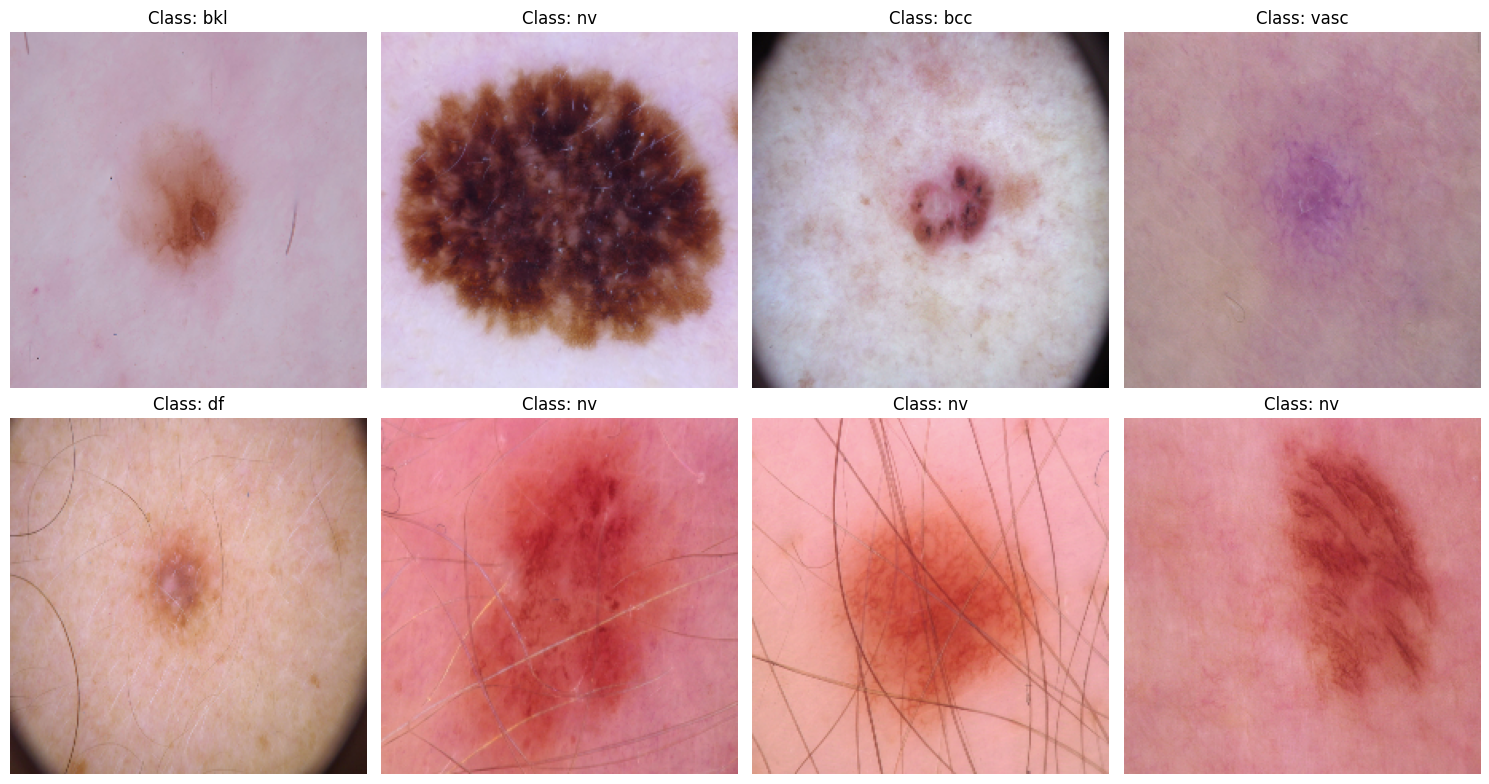

In [ ]:
Data_Root= "/content/drive/MyDrive/base_dir"
dataset = HAM10000Dataset(
    dataset_root=Data_Root,
    image_size=(224, 224),
    augment=True
)

# Display 8 random samples
dataset.visualize_samples(n_samples=8, figsize=(15, 8))

In [ ]:
print(dataset)
img, label = dataset[0]
print(f"Image shape: {img.shape}")
print(f"Label: {label}")
print(f"Image dtype: {img.dtype}")

Image shape: torch.Size([3, 224, 224])
Label: 0
Image dtype: torch.float32


In [ ]:
SUBSET_JSON = "/content/Processed/subset_indices_300.json"
SUBSET_SIZE = 300
SEED = 42

In [ ]:
'''Creating subset of 300 images for Pheumonia detection task'''
import json
from pathlib import Path
from typing import Optional, List, Dict
import numpy as np
from collections import defaultdict
from torch.utils.data import Subset

def _rng(seed: int):
    """Return a numpy Generator for reproducible sampling."""
    return np.random.default_rng(seed)

def create_subset_indices(
    dataset,
    subset_size: Optional[int] = None,
    per_class: Optional[int] = None,
    seed: int = 42,
    save_path: str = "data/processed/subset_indices.json",
    patient_col: Optional[str] = None
) -> Dict:
    rng = _rng(seed)

    # Validate dataset exposes labels
    if not hasattr(dataset, "labels"):
        raise ValueError("Dataset must expose `labels` (list or array) in the same order as indexing.")

    labels_arr = np.array(dataset.labels)
    unique_classes = np.unique(labels_arr).tolist()
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)

    '''This block samples patients instead of images to avoid data leakage. It requires a patient identifier column
    in the dataset's dataframe (dataset.df) to group images'''
    if patient_col and hasattr(dataset, "df") and patient_col in dataset.df.columns:
        # build patient -> list(indices) mapping and patient -> class mapping (dominant label)
        patient_to_indices = defaultdict(list)
        for idx, pid in enumerate(dataset.df[patient_col].values):
            patient_to_indices[pid].append(idx)

        # map patient -> class (majority class of that patient's images)
        patient_to_class = {}
        for pid, inds in patient_to_indices.items():
            labs = labels_arr[inds]
            # majority label for patient
            vals, counts = np.unique(labs, return_counts=True)
            patient_to_class[pid] = int(vals[np.argmax(counts)])

        # Prepare per-class list of patients
        class_to_patients = defaultdict(list)
        for pid, cls in patient_to_class.items():
            class_to_patients[int(cls)].append(pid)

        indices_selected = []

        if per_class is not None:
            # select patients per class until we have enough images or hit patient count
            for cls in unique_classes:
                pats = class_to_patients[int(cls)]
                rng.shuffle(pats)
                sel_pats = []
                img_count = 0
                for p in pats:
                    sel_pats.append(p)
                    img_count += len(patient_to_indices[p])
                    if img_count >= per_class:
                        break
                # expand to indices
                for p in sel_pats:
                    indices_selected.extend(patient_to_indices[p])
        else:
            # sample patients (balanced across classes proportionally) until >= subset_size images
            # flatten a patient list with class labels to sample from
            all_patients = list(patient_to_indices.keys())
            rng.shuffle(all_patients)
            selected_patients = []
            total_images = 0
            # simple greedy collect until reaching subset_size
            for p in all_patients:
                selected_patients.append(p)
                total_images += len(patient_to_indices[p])
                if subset_size is not None and total_images >= subset_size:
                    break
            for p in selected_patients:
                indices_selected.extend(patient_to_indices[p])

        indices = np.array(sorted(set(indices_selected)), dtype=int)

    else:

        class_indices = {int(c): np.where(labels_arr == c)[0] for c in unique_classes}

        if per_class is not None:
            # sample exactly per_class from each class (if available)
            indices = []
            for cls, inds in class_indices.items():
                if len(inds) < per_class:
                    raise ValueError(f"Not enough samples in class {cls}: requested {per_class}, available {len(inds)}")
                sel = rng.choice(inds, size=per_class, replace=False)
                indices.append(sel)
            indices = np.concatenate(indices)
        else:
            # stratified sampling proportional to class frequencies
            if subset_size is None:
                raise ValueError("Either subset_size or per_class must be provided.")
            # compute class quotas (rounding: last class gets remainder)
            counts = {cls: len(inds) for cls, inds in class_indices.items()}
            total_available = sum(counts.values())
            proportions = {cls: counts[cls] / total_available for cls in counts}
            indices = []
            remaining = subset_size
            classes = list(class_indices.keys())
            for i, cls in enumerate(classes):
                if i == len(classes) - 1:
                    k = remaining
                else:
                    k = int(round(proportions[cls] * subset_size))
                    remaining -= k
                k = min(k, len(class_indices[cls]))
                sel = rng.choice(class_indices[cls], size=k, replace=False)
                indices.append(sel)
            indices = np.concatenate(indices)
    # final shuffle of indices
    indices = np.array(indices, dtype=int)
    rng.shuffle(indices)

    info = {
        "indices": indices.tolist(),
        "subset_size": len(indices),
        "seed": int(seed),
        "per_class": int(per_class) if per_class is not None else None,
        "patient_level": bool(patient_col is not None and hasattr(dataset, "df") and patient_col in dataset.df.columns),
    }
    # compute class counts
    unique, counts = np.unique(labels_arr[indices], return_counts=True)
    info["class_counts"] = {int(u): int(c) for u, c in zip(unique.tolist(), counts.tolist())}

    with open(save_path, "w") as f:
        json.dump(info, f, indent=2)

    print(f"[subset_utils] Saved subset indices ({info['subset_size']}) to {save_path}")
    return info


def load_subset(dataset, indices_path: str = "data/processed/subset_indices.json"):
    path = Path(indices_path)
    if not path.exists():
        raise FileNotFoundError(f"Subset indices JSON not found: {path}")
    with open(path, "r") as f:
        info = json.load(f)
    indices = info["indices"]
    print(f"[subset_utils] Loaded {len(indices)} indices from {indices_path}")
    return Subset(dataset, indices) # return a Subset object

In [ ]:
info = create_subset_indices(
    dataset= dataset,
    subset_size=SUBSET_SIZE,
    seed=SEED,
    save_path=SUBSET_JSON,
    patient_col=None
)
print("Created subset JSON files:", info)
print("Class counts in subset:", info["class_counts"])

[subset_utils] Saved subset indices (300) to /content/Processed/subset_indices_300.json
Created subset JSON files: {'indices': [3007, 5899, 9648, 6249, 721, 1428, 5926, 374, 2669, 4266, 6415, 8818, 7251, 982, 5279, 5361, 2320, 5713, 1049, 4097, 4783, 5230, 3153, 4232, 30, 2765, 5033, 2667, 6600, 6392, 888, 1361, 1653, 4002, 6725, 2141, 1577, 4873, 1672, 8507, 4661, 3775, 9928, 9581, 9254, 6397, 7984, 3467, 4347, 5377, 9421, 7062, 6113, 9121, 9447, 8156, 1836, 3722, 2748, 1887, 1351, 3441, 6805, 3138, 744, 2314, 139, 7273, 4903, 7035, 2506, 9515, 9105, 7517, 4118, 7851, 1007, 3295, 4874, 6202, 6073, 4739, 9991, 6229, 6752, 2779, 2531, 2178, 5106, 3798, 557, 2566, 1341, 2388, 6613, 5171, 5413, 3789, 2119, 226, 6773, 4492, 1641, 4722, 9794, 4888, 9886, 4249, 8463, 7283, 3311, 1460, 5261, 9094, 612, 604, 8101, 65, 5576, 7512, 3887, 5051, 9521, 8143, 9123, 1991, 7204, 8015, 7397, 7596, 6104, 6349, 8640, 552, 2888, 6071, 418, 6858, 3596, 4088, 577, 3943, 9364, 6082, 2927, 3315, 6946, 794, 20

In [ ]:
import os
import time
import csv
from pathlib import Path
from typing import Optional, Dict, Tuple, List
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast

# optional metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
try:
    from sklearn.metrics import roc_auc_score
    _HAS_AUC = True
except Exception:
    _HAS_AUC = False

class ModelBTrainer:
    def __init__(
        self,
        model: nn.Module,
        device: torch.device,
        train_loader,
        val_loader,
        test_loader = None,
        save_dir: str = "experiments",
        experiment_name: str = "run",
        use_amp: bool = True,
        clip_grad_norm: Optional[float] = 1.0,
        monitor: str = "val_auc",   # "val_auc" | "val_loss" | "val_acc"
        log_interval: int = 50,
        save_interval: int = 10,
    ):
        self.model = model
        self.device = device if isinstance(device, torch.device) else torch.device(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.use_amp = use_amp
        self.scaler = GradScaler(enabled=use_amp)
        self.clip_grad_norm = clip_grad_norm
        # logging & saving
        self.base_dir = Path(save_dir) / experiment_name
        self.base_dir.mkdir(parents=True, exist_ok=True)
        self.checkpoint_dir = self.base_dir / "checkpoints"
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)
        self.best_model_path =  self.base_dir / "best_model.pth"
        self.csv_log = self.base_dir / "training_log.csv"

        # training state
        self.monitor = monitor
        self.best_metric = -float("inf") if monitor != "val_loss" else float("inf")
        self.best_epoch = None
        self.no_improve_epochs = 0
        self.log_interval = log_interval
        self.save_interval = save_interval

          # history dict
        self.history: Dict[str, List] = {
            "train_loss": [], "train_acc": [],
            "val_loss": [], "val_acc": [], "val_precision": [],
            "val_recall": [], "val_f1": [], "val_auc": [],
            "lrs": [], "epoch_time_s": []
        }

        # move model to device
        self.model.to(self.device)

        # initialize CSV header
        if not self.csv_log.exists():
            with open(self.csv_log, "w", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    "epoch", "train_loss", "train_acc",
                    "val_loss", "val_acc", "val_precision", "val_recall", "val_f1", "val_auc",
                    "lr", "epoch_time_s"
                ])

    def train_epoch(self, criterion, optimizer, epoch: int, num_epochs: int) -> Tuple[float, float, List[int], List[int]]:
        self.model.train()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        scaler = self.scaler

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False, ncols=120)
        for batch_idx, (images, labels) in enumerate(pbar):
            images = images.to(self.device, non_blocking=True)
            labels = labels.to(self.device, non_blocking=True)

            optimizer.zero_grad()
            if self.use_amp:
                with autocast():
                    outputs = self.model(images)
                    loss = criterion(outputs, labels)
                scaler.scale(loss).backward()
                if self.clip_grad_norm is not None:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = self.model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                if self.clip_grad_norm is not None:
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad_norm)
                optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.detach().cpu().numpy().tolist())

            avg_loss = running_loss / (batch_idx + 1)
            current_acc = accuracy_score(all_labels, all_preds)
            if (batch_idx + 1) % self.log_interval == 0 or (batch_idx + 1) == len(self.train_loader):
                pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{current_acc:.4f}'})

        epoch_loss = running_loss / max(1, len(self.train_loader))
        epoch_acc = accuracy_score(all_labels, all_preds)
        return epoch_loss, epoch_acc, all_preds, all_labels

    def validate_epoch(self, criterion, epoch: int, num_epochs: int, loader=None) -> Tuple[float, float, float, float, float, List[int], List[int]]:

        if loader is None:
            loader = self.val_loader
        self.model.eval()
        running_loss = 0.0
        all_preds = []
        all_labels = []
        all_probs = []  # for AUC if available

        pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]  ", leave=False, ncols=120)
        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(pbar):
                images = images.to(self.device, non_blocking=True)
                labels = labels.to(self.device, non_blocking=True)

                if self.use_amp:
                    with autocast():
                        outputs = self.model(images)
                else:
                    outputs = self.model(images)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                probs = torch.softmax(outputs, dim=1)
                preds = outputs.argmax(dim=1)
                all_preds.extend(preds.detach().cpu().numpy().tolist())
                all_labels.extend(labels.detach().cpu().numpy().tolist())

                if _HAS_AUC and outputs.size(1) == 2:
                    all_probs.append(probs[:, 1].detach().cpu().numpy())

                avg_loss = running_loss / (batch_idx + 1)
                current_acc = accuracy_score(all_labels, all_preds)
                if (batch_idx + 1) % self.log_interval == 0 or (batch_idx + 1) == len(loader):
                    pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'acc': f'{current_acc:.4f}'})

        val_loss = running_loss / max(1, len(loader))
        val_acc = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=0)

        val_auc = None
        if _HAS_AUC and len(all_probs) > 0:
            try:
                import numpy as _np
                y_score = _np.concatenate(all_probs, axis=0)
                y_true = _np.array(all_labels)
                val_auc = float(roc_auc_score(y_true, y_score))
            except Exception:
                val_auc = None

        return val_loss, val_acc, precision, recall, f1, val_auc, all_preds, all_labels


    def _is_better(self, metric_val: float) -> bool:
        """Return True if metric_val is an improvement per chosen monitor."""
        if self.monitor == "val_loss":
            return metric_val < self.best_metric
        else:
            return metric_val > self.best_metric

    def _update_best(self, metric_val: float, epoch: int):
        if self.best_epoch is None:
            # initialize best_metric properly
            self.best_metric = metric_val
            self.best_epoch = epoch
            return True
        better = (metric_val < self.best_metric) if (self.monitor == "val_loss") else (metric_val > self.best_metric)
        if better:
            self.best_metric = metric_val
            self.best_epoch = epoch
            return True
        return False

    def save_checkpoint(self, epoch: int, optimizer, scheduler=None, is_best: bool = False):
        path = self.checkpoint_dir / f"checkpoint_epoch_{epoch:03d}.pt"
        ck = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict() if scheduler is not None else None,
            "best_metric": self.best_metric
        }
        if self.use_amp:
            ck["scaler_state_dict"] = self.scaler.state_dict()
        torch.save(ck, path)
        if is_best:
            torch.save(self.model.state_dict(), self.best_model_path)
        return path


    def fit(
        self,
        num_epochs: int,
        optimizer,
        criterion = None,
        scheduler = None,
        resume_checkpoint: Optional[str] = None,
        save_best_only: bool = True,
        verbose: bool = True
    ) -> Dict:

        if criterion is None:
            criterion = nn.CrossEntropyLoss()

        start_epoch = 1
        # resume checkpoint if given
        if resume_checkpoint:
            ck = torch.load(resume_checkpoint, map_location=self.device)
            self.model.load_state_dict(ck["model_state_dict"])
            if "optimizer_state_dict" in ck and ck["optimizer_state_dict"] is not None:
                optimizer.load_state_dict(ck["optimizer_state_dict"])
            if scheduler is not None and "scheduler_state_dict" in ck and ck["scheduler_state_dict"] is not None:
                try:
                    scheduler.load_state_dict(ck["scheduler_state_dict"])
                except Exception:
                    pass
            if self.use_amp and "scaler_state_dict" in ck and ck["scaler_state_dict"] is not None:
                try:
                    self.scaler.load_state_dict(ck["scaler_state_dict"])
                except Exception:
                    pass
            start_epoch = ck.get("epoch", 0) + 1
            if verbose:
                print(f"[resume] loaded checkpoint {resume_checkpoint}, starting epoch {start_epoch}")

        if verbose:
            print("\n" + "="*80)
            print("Starting training (Model C)")
            print(f"Device: {self.device}")
            print(f"Train samples: {len(self.train_loader.dataset)}  Val samples: {len(self.val_loader.dataset)}")
            print(f"Batch size: {self.train_loader.batch_size}")
            print("="*80 + "\n")

        for epoch in range(start_epoch, num_epochs + 1):
            epoch_t0 = time.time()

            train_loss, train_acc, _, _ = self.train_epoch(criterion, optimizer, epoch-1, num_epochs)
            val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = self.validate_epoch(criterion, epoch-1, num_epochs)

            # scheduler step (handle ReduceLROnPlateau separately)
            if scheduler is not None:
                if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    # ReduceLROnPlateau expects a metric to monitor; using val_loss here
                    if self.monitor == "val_loss":
                        scheduler.step(val_loss)
                    else:
                        # if monitor is val_auc or val_acc, pass that metric (prefers val_auc)
                        metric_for_scheduler = val_auc if (val_auc is not None) else val_acc
                        scheduler.step(metric_for_scheduler)
                else:
                    try:
                        scheduler.step()
                    except Exception:
                        pass

            epoch_time = time.time() - epoch_t0
            current_lr = optimizer.param_groups[0]["lr"]

            # record history
            self.history["train_loss"].append(train_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_loss"].append(val_loss)
            self.history["val_acc"].append(val_acc)
            self.history["val_precision"].append(val_prec)
            self.history["val_recall"].append(val_rec)
            self.history["val_f1"].append(val_f1)
            self.history["val_auc"].append(val_auc if val_auc is not None else float("nan"))
            self.history["lrs"].append(current_lr)
            self.history["epoch_time_s"].append(epoch_time)

            # CSV logging
            with open(self.csv_log, "a", newline="") as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch, f"{train_loss:.6f}", f"{train_acc:.4f}",
                    f"{val_loss:.6f}", f"{val_acc:.4f}", f"{val_prec:.4f}",
                    f"{val_rec:.4f}", f"{val_f1:.4f}", f"{val_auc if val_auc is not None else 'nan'}",
                    f"{current_lr:.6e}", f"{epoch_time:.1f}"
                ])

            # print brief summary
            print(f"[Epoch {epoch}/{num_epochs}] train_loss={train_loss:.4f} train_acc={train_acc:.4f} "
                  f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} val_auc={val_auc} lr={current_lr:.2e} time={epoch_time:.1f}s")

            # checkpointing
            if self.monitor == "val_loss":
                metric_val = val_loss
            elif self.monitor == "val_auc":
                metric_val = val_auc if val_auc is not None else val_acc
            else:
                metric_val = val_acc

            improved = False
            if self.best_epoch is None:
                self.best_epoch = epoch
                self.best_metric = metric_val
                improved = True
            else:
                # for val_loss lower is better, for others higher is better
                if self.monitor == "val_loss":
                    if metric_val < self.best_metric:
                        improved = True
                else:
                    if metric_val is not None and metric_val > self.best_metric:
                        improved = True

            if improved:
                self.best_metric = metric_val
                self.best_epoch = epoch
                self.save_checkpoint(epoch, optimizer, scheduler, is_best=True)
                self.no_improve_epochs = 0
                print(f"  ✓ New best model (epoch {epoch}) saved. {self.monitor} = {metric_val}")
            else:
                self.no_improve_epochs += 1
                if epoch % self.save_interval == 0:
                    self.save_checkpoint(epoch, optimizer, scheduler, is_best=False)


        if self.best_model_path.exists():
            self.model.load_state_dict(torch.load(self.best_model_path, map_location=self.device))
            if verbose:
                print(f"\n✓ Loaded best model from epoch {self.best_epoch}")
        # end epochs
        # load best model for final evaluation if exists
        test_results = None
        if self.test_loader is not None:
            test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, _, _ = self.validate_epoch(
                criterion, -1, num_epochs, loader=self.test_loader
            )

            test_results = {
                "test_loss": test_loss,
                "test_acc": test_acc,
                "test_precision": test_prec,
                "test_recall": test_rec,
                "test_f1": test_f1,
                "test_auc": test_auc
            }

            print(f"\n{'='*80}")
            print("FINAL TEST RESULTS")
            print(f"{'='*80}")
            print(f"  Loss:      {test_loss:.4f}")
            print(f"  Accuracy:  {test_acc:.4f}")
            print(f"  Precision: {test_prec:.4f}")
            print(f"  Recall:    {test_rec:.4f}")
            print(f"  F1-Score:  {test_f1:.4f}")
            print(f"  AUC:       {test_auc if test_auc is not None else 'N/A'}")
            print(f"{'='*80}")

        return {
            "history": self.history,
            "best_metric": self.best_metric,
            "best_epoch": self.best_epoch,
            "test_results": test_results,
        }


        return {
            "history": self.history,
            "best_metric": self.best_metric,
            "best_epoch": self.best_epoch,
            "test_results": test_results,
        }

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from typing import Optional
class ClassificationHead(nn.Module):
    """MLP classification head for feature vectors."""

    def __init__(self, input_dim: int, num_classes: int, dropout_rate: float = 0.3):
        super().__init__()

        self.classifier = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Dropout(dropout_rate),
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(x)


class DenseNet121Classifier(nn.Module):

    def __init__(
        self,
        num_classes: int = 2,
        dropout_rate: float = 0.3,
        pretrained: bool = True,
        freeze_backbone: bool = True,
    ):
        super().__init__()

        # Load pretrained DenseNet121
        weights = models.DenseNet121_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.densenet121(weights=weights)

        # Get feature dimension
        self.feature_dim = self.backbone.classifier.in_features
        # Remove original classifier
        self.backbone.classifier = nn.Identity()

        # Freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone frozen (feature extraction mode)")

        # Add custom classification head
        self.classification_head = ClassificationHead(
            input_dim=self.feature_dim,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
        )

        self._print_param_info()

    def _print_param_info(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen = total - trainable

        print(f"\n{'='*60}")
        print("DenseNet121 Classifier")
        print(f"{'='*60}")
        print(f"Feature dimension: {self.feature_dim}")
        print(f"Total parameters: {total:,}")
        print(f"Trainable parameters: {trainable:,}")
        print(f"Frozen parameters: {frozen:,}")
        print(f"Trainable %: {100 * trainable / total:.2f}%")
        print(f"{'='*60}\n")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        features = self.backbone(x)
        logits = self.classification_head(features)
        return logits

    def unfreeze_backbone(self, unfreeze_layers: Optional[int] = None):

        if unfreeze_layers is None:
            for param in self.backbone.parameters():
                param.requires_grad = True
            print("Entire backbone unfrozen")
        else:
            # DenseNet121 has 4 dense blocks
            dense_blocks = ["denseblock4", "denseblock3", "denseblock2", "denseblock1"]
            transitions = ["transition3", "transition2", "transition1"]

            blocks_to_unfreeze = dense_blocks[:unfreeze_layers]
            trans_to_unfreeze = transitions[:max(0, unfreeze_layers - 1)]

            for name, param in self.backbone.named_parameters():
                for block in blocks_to_unfreeze + trans_to_unfreeze:
                    if block in name:
                        param.requires_grad = True
                        break

            print(f"Unfroze last {unfreeze_layers} dense block(s)")

        self._print_param_info()


In [ ]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='torch')

# Necessary imports for the redefined train_with_kfold function
import json
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import numpy as np # Used for np.mean, np.std, and np.isnan
import math # Kept for older math.isnan calls in summary, replaced with np.isnan

# Redefine the train_with_kfold function with the fix
def train_with_kfold(Data_Root, SUBSET_JSON, BATCH_SIZE,
        NUM_WORKERS, NUM_EPOCHS, device, n_folds):

    # 1. Load subset indices
    with open(SUBSET_JSON, 'r') as f:
        subset_data = json.load(f)
    subset_indices = subset_data['indices']  # Extract indices

    full_dataset = HAM10000Dataset(
        dataset_root=Data_Root,
        split=None,
        augment=False,
        normalize=False,
        image_size=(224, 224)
    )
    # Extract the images and labels from the subset JSON
    all_images_for_kfold = [full_dataset.all_images[i] for i in subset_indices]
    all_labels_for_kfold = [full_dataset.all_labels[i] for i in subset_indices]

    # Get the global class names from the full dataset
    global_classes = full_dataset.classes # <--- FIX: Get global class names
    num_classes_model = len(global_classes) # Number of classes for the model

    print(f"Loaded {len(all_images_for_kfold)} images from {SUBSET_JSON}.")
    print(f"Class distribution: {subset_data.get('class_counts', 'N/A')}")

    test_dataset = HAM10000Dataset(
        dataset_root= Data_Root,
        split="test",
        train_ratio=0.7,
        val_ratio=0.15,
        test_ratio=0.15,
        random_seed=42,
        augment=False,
        normalize=True,
        image_size=(224, 224)
    )
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    print(f"Test dataset loaded with {len(test_dataset)} images.")

    # Initialize k-fold splitter (stratified to maintain class balance)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(all_images_for_kfold, all_labels_for_kfold)):
        print(f"\n{'='*60}")
        print(f"FOLD {fold_idx + 1}/{n_folds} - DenseNet-121 (From Scratch)")
        print(f"{'='*60}")
        print(f"Train samples: {len(train_idx)}, Val samples: {len(val_idx)}")

        # Prepare images and labels for current fold's train/val datasets
        fold_train_images = [all_images_for_kfold[i] for i in train_idx]
        fold_train_labels = [all_labels_for_kfold[i] for i in train_idx]
        fold_val_images = [all_images_for_kfold[i] for i in val_idx]
        fold_val_labels = [all_labels_for_kfold[i] for i in val_idx] # <--- FIX: Corrected val_labels source

        # Create CustomDataset for this fold using provided images/labels
        train_ds_fold = CustomDataset(
            provided_images=fold_train_images,
            provided_labels=fold_train_labels,
            all_dataset_classes=global_classes, # <--- FIX: Added this parameter
            split="train",
            augment=True,
            normalize=True,
            image_size=(224, 224)
        )
        val_ds_fold = CustomDataset(
            provided_images=fold_val_images,
            provided_labels=fold_val_labels,
            all_dataset_classes=global_classes, # <--- FIX: Added this parameter
            split="val",
            augment=False,
            normalize=True,
            image_size=(224, 224)
        )

        train_loader = DataLoader(
            train_ds_fold,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_ds_fold,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
        print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")

        #Model
        model = DenseNet121Classifier(
            num_classes=2,
            dropout_rate=0.3,
            pretrained=True,
            freeze_backbone=True

    )
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        trainer = ModelATrainer(
            model=model,
            device=device,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            experiment_name="densenet_HAM10000_run1",
            use_amp=True,
            clip_grad_norm=1.0,
            log_interval=10,
            save_interval=10,
        )
        results = trainer.fit(num_epochs=NUM_EPOCHS,
                              optimizer=optimizer,
                              scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max',factor=0.5, min_lr=1e-6, patience=4))

        fold_results.append({
            'fold': fold_idx + 1,
            'best_val_acc': results['best_metric'] * 100,
            'test_acc': results['test_results']['test_acc'] * 100 if results['test_results'] else float('nan'),
            'test_auc': results['test_results']['test_auc'] if results['test_results'] else float('nan')
        })


    # Summary across all folds
    print(f"\n{'='*60}")
    print("K-FOLD CROSS-VALIDATION SUMMARY")
    print(f"{'='*60}")

    test_accs = [r['test_acc'] for r in fold_results if not np.isnan(r['test_acc'])] # <--- FIX: Changed math.isnan to np.isnan
    test_aucs = [r['test_auc'] for r in fold_results if r['test_auc'] is not None and not np.isnan(r['test_auc'])] # <--- FIX: Changed math.isnan to np.isnan

    if test_accs:
        print(f"\nTest Accuracy: {np.mean(test_accs):.2f}% \u00b1 {np.std(test_accs):.2f}%")
    else:
        print("\nTest Accuracy: Not calculated (no test_dataset provided).")

    if test_aucs:
        print(f"Test AUC: {np.mean(test_aucs):.4f} \u00b1 {np.std(test_aucs):.4f}")
    else:
        print("Test AUC: Not calculated (no test_dataset provided).")

    print(f"\nDetailed Results:")
    for r in fold_results:
        test_acc_str = f"{r['test_acc']:.2f}%" if not np.isnan(r['test_acc']) else "N/A" # <--- FIX: Changed math.isnan to np.isnan
        test_auc_str = f"{r['test_auc']:.4f}" if r['test_auc'] is not None and not np.isnan(r['test_auc']) else "N/A" # <--- FIX: Changed math.isnan to np.isnan
        print(f"  Fold {r['fold']}: Val Acc={r['best_val_acc']:.2f}%, Test Acc={test_acc_str}, Test AUC={test_auc_str}")


SUBSET_JSON = "/content/Processed/subset_indices_300.json"
BATCH_SIZE = 8
NUM_WORKERS = 2
NUM_EPOCHS = 20

fold_results = train_with_kfold(
        Data_Root=Data_Root,
        SUBSET_JSON=SUBSET_JSON,
        BATCH_SIZE=BATCH_SIZE,
        NUM_WORKERS=NUM_WORKERS,
        NUM_EPOCHS=NUM_EPOCHS,
        device=device,
        n_folds=3, # Reduced from 5 to 3
    )

print("\n✓ K-Fold training completed successfully!")

Total images found: 10015
Loaded 10015 images
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'akiec': 327, 'bcc': 514, 'bkl': 1099, 'df': 115, 'mel': 1113, 'nv': 6705, 'vasc': 142}
Loaded 300 images from /content/Processed/subset_indices_300.json.
Class distribution: {'0': 10, '1': 15, '2': 33, '3': 3, '4': 33, '5': 201, '6': 5}
Total images found: 10015
Loaded 1503 images from test split
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'nv': 1006, 'mel': 167, 'bkl': 165, 'bcc': 77, 'df': 17, 'akiec': 49, 'vasc': 22}
Test dataset loaded with 1503 images.

FOLD 1/3 - DenseNet-121 (From Scratch)
Train samples: 200, Val samples: 100
Loaded 200 provided images for train split.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'mel': 22, 'nv': 134, 'bcc': 10, 'bkl': 22, 'akiec': 6, 'vasc': 4, 'df': 2}
Loaded 100 provided images for val split.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', '

Epoch 1/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 1/20] train_loss=1.2418 train_acc=0.6450 val_loss=2.7181 val_acc=0.6700 val_f1=0.1146 val_auc=nan lr=1.00e-03 time=96.0s
  ✓ New best model (epoch 1) saved. val_auc = 0.67


Epoch 2/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 2/20] train_loss=1.1982 train_acc=0.6550 val_loss=1.3525 val_acc=0.6700 val_f1=0.1146 val_auc=0.596927181537324 lr=1.00e-03 time=11.0s


Epoch 3/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 3/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 3/20] train_loss=1.1346 train_acc=0.6450 val_loss=1.2039 val_acc=0.6700 val_f1=0.2098 val_auc=nan lr=1.00e-03 time=11.4s


Epoch 4/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 4/20] train_loss=1.1164 train_acc=0.6200 val_loss=1.4819 val_acc=0.6700 val_f1=0.1146 val_auc=0.6058689569896618 lr=1.00e-03 time=18.6s


Epoch 5/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 5/20] train_loss=1.0649 train_acc=0.6750 val_loss=1.0621 val_acc=0.6600 val_f1=0.1330 val_auc=0.7095475609789647 lr=1.00e-03 time=20.3s
  ✓ New best model (epoch 5) saved. val_auc = 0.7095475609789647


Epoch 6/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 6/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 6/20] train_loss=1.0567 train_acc=0.6700 val_loss=1.0218 val_acc=0.6800 val_f1=0.1558 val_auc=nan lr=1.00e-03 time=10.7s


Epoch 7/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 7/20] train_loss=1.0362 train_acc=0.6750 val_loss=1.2696 val_acc=0.6100 val_f1=0.1767 val_auc=nan lr=1.00e-03 time=20.1s


Epoch 8/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>^
^Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^    ^self._shutdown_workers()^^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^

   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process' 
     ^ ^ ^  ^  ^^  ^ ^^^^^^^^^^^^
^  Fi

Epoch 8/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 8/20] train_loss=1.1452 train_acc=0.6450 val_loss=1.1344 val_acc=0.6300 val_f1=0.1449 val_auc=0.7561599550460988 lr=1.00e-03 time=9.6s
  ✓ New best model (epoch 8) saved. val_auc = 0.7561599550460988


Epoch 9/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

Traceback (most recent call last):
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

     if w.is_alive():
            ^ ^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._par

Epoch 9/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 9/20] train_loss=1.0751 train_acc=0.6700 val_loss=1.1027 val_acc=0.6500 val_f1=0.1864 val_auc=nan lr=1.00e-03 time=11.7s


Epoch 10/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 10/20] train_loss=1.0653 train_acc=0.6500 val_loss=1.0418 val_acc=0.6900 val_f1=0.1600 val_auc=nan lr=1.00e-03 time=20.1s


Epoch 11/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 11/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 11/20] train_loss=1.0699 train_acc=0.6400 val_loss=1.3838 val_acc=0.6700 val_f1=0.1153 val_auc=nan lr=1.00e-03 time=11.6s


Epoch 12/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 12/20] train_loss=0.9772 train_acc=0.6650 val_loss=1.1426 val_acc=0.5400 val_f1=0.1811 val_auc=nan lr=1.00e-03 time=18.9s


Epoch 13/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 13/20] train_loss=1.0020 train_acc=0.6450 val_loss=1.2587 val_acc=0.6200 val_f1=0.1603 val_auc=nan lr=5.00e-04 time=22.3s


Epoch 14/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 14/20] train_loss=0.9606 train_acc=0.6500 val_loss=1.0452 val_acc=0.6100 val_f1=0.1955 val_auc=nan lr=5.00e-04 time=18.5s


Epoch 15/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers()   
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
   ^^ ^  ^ ^^^^^^^^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
 
    File "/usr/lib/pyt

Epoch 15/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 15/20] train_loss=0.9909 train_acc=0.6500 val_loss=1.1439 val_acc=0.6800 val_f1=0.1596 val_auc=nan lr=5.00e-04 time=11.9s


Epoch 16/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 16/20] train_loss=0.9759 train_acc=0.6750 val_loss=1.0567 val_acc=0.6900 val_f1=0.2019 val_auc=nan lr=5.00e-04 time=18.7s


Epoch 17/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 17/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 17/20] train_loss=0.9513 train_acc=0.6700 val_loss=1.0663 val_acc=0.6500 val_f1=0.1442 val_auc=0.7632885277362157 lr=5.00e-04 time=21.7s
  ✓ New best model (epoch 17) saved. val_auc = 0.7632885277362157


Epoch 18/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 18/20] train_loss=0.9483 train_acc=0.6600 val_loss=1.0759 val_acc=0.6800 val_f1=0.1886 val_auc=0.7752941769904819 lr=5.00e-04 time=11.1s
  ✓ New best model (epoch 18) saved. val_auc = 0.7752941769904819


Epoch 19/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 19/20] train_loss=0.9120 train_acc=0.6850 val_loss=1.0349 val_acc=0.7000 val_f1=0.2188 val_auc=nan lr=5.00e-04 time=10.9s


Epoch 20/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 20/20] train_loss=0.8759 train_acc=0.6800 val_loss=1.0589 val_acc=0.6800 val_f1=0.1911 val_auc=nan lr=5.00e-04 time=19.2s

✓ Loaded best model from epoch 18


Epoch 0/20 [Val]  :   0%|                                                                       | 0/188 [00:00…


FINAL TEST RESULTS
  Loss:      0.9687
  Accuracy:  0.6700
  Precision: 0.2276
  Recall:    0.1927
  F1-Score:  0.1819
  AUC:       N/A

FOLD 2/3 - DenseNet-121 (From Scratch)
Train samples: 200, Val samples: 100
Loaded 200 provided images for train split.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'mel': 22, 'nv': 134, 'bkl': 22, 'bcc': 10, 'vasc': 3, 'akiec': 7, 'df': 2}
Loaded 100 provided images for val split.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'nv': 67, 'bcc': 5, 'mel': 11, 'bkl': 11, 'akiec': 3, 'vasc': 2, 'df': 1}
Train batches: 25, Val batches: 13

Starting training (Model C)
Device: cuda
Train samples: 200  Val samples: 100
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 1/20] train_loss=1.2192 train_acc=0.6150 val_loss=1.4956 val_acc=0.6600 val_f1=0.1555 val_auc=0.581315453497459 lr=1.00e-03 time=11.9s
  ✓ New best model (epoch 1) saved. val_auc = 0.581315453497459


Epoch 2/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 2/20] train_loss=1.1485 train_acc=0.6650 val_loss=1.1934 val_acc=0.6700 val_f1=0.1146 val_auc=nan lr=1.00e-03 time=9.5s
  ✓ New best model (epoch 2) saved. val_auc = 0.67


Epoch 3/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 3/20] train_loss=1.1642 train_acc=0.6450 val_loss=1.0348 val_acc=0.6700 val_f1=0.1146 val_auc=0.7266879592138162 lr=1.00e-03 time=11.5s
  ✓ New best model (epoch 3) saved. val_auc = 0.7266879592138162


Epoch 4/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 4/20] train_loss=1.0896 train_acc=0.6650 val_loss=1.0822 val_acc=0.6600 val_f1=0.1136 val_auc=nan lr=1.00e-03 time=10.8s


Epoch 5/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 5/20] train_loss=1.0874 train_acc=0.6700 val_loss=1.0067 val_acc=0.6600 val_f1=0.1143 val_auc=0.7134704339815132 lr=1.00e-03 time=20.4s


Epoch 6/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 6/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 6/20] train_loss=1.0842 train_acc=0.6500 val_loss=1.0276 val_acc=0.6800 val_f1=0.1391 val_auc=nan lr=1.00e-03 time=9.4s


Epoch 7/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 7/20] train_loss=1.0732 train_acc=0.6700 val_loss=1.0106 val_acc=0.6700 val_f1=0.1146 val_auc=nan lr=1.00e-03 time=21.9s


Epoch 8/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 8/20] train_loss=1.0279 train_acc=0.6650 val_loss=0.9825 val_acc=0.6900 val_f1=0.1707 val_auc=0.7305247276145168 lr=1.00e-03 time=18.8s
  ✓ New best model (epoch 8) saved. val_auc = 0.7305247276145168


Epoch 9/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 9/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 9/20] train_loss=1.0592 train_acc=0.6650 val_loss=1.0400 val_acc=0.6400 val_f1=0.1115 val_auc=nan lr=1.00e-03 time=11.3s


Epoch 10/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 10/20] train_loss=1.0513 train_acc=0.6650 val_loss=1.0734 val_acc=0.6100 val_f1=0.1346 val_auc=nan lr=1.00e-03 time=19.0s


Epoch 11/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 11/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 11/20] train_loss=1.0346 train_acc=0.6600 val_loss=0.9410 val_acc=0.6800 val_f1=0.2063 val_auc=0.7931582344700786 lr=1.00e-03 time=12.0s
  ✓ New best model (epoch 11) saved. val_auc = 0.7931582344700786


Epoch 12/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():
^^  ^ ^ ^^ ^ ^ ^^^^^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^  ^^ 
  File "/usr/lib/pyt

Epoch 12/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 12/20] train_loss=1.0140 train_acc=0.6850 val_loss=2.3860 val_acc=0.3800 val_f1=0.1086 val_auc=nan lr=1.00e-03 time=12.2s


Epoch 13/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 13/20] train_loss=1.0233 train_acc=0.6500 val_loss=1.0085 val_acc=0.6600 val_f1=0.1136 val_auc=nan lr=1.00e-03 time=18.8s


Epoch 14/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 14/20] train_loss=0.9724 train_acc=0.6700 val_loss=1.1108 val_acc=0.6300 val_f1=0.1324 val_auc=0.8026476998741021 lr=1.00e-03 time=20.5s
  ✓ New best model (epoch 14) saved. val_auc = 0.8026476998741021


Epoch 15/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 15/20] train_loss=0.9968 train_acc=0.6550 val_loss=1.0778 val_acc=0.6200 val_f1=0.1712 val_auc=nan lr=1.00e-03 time=11.2s


Epoch 16/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 16/20] train_loss=0.9979 train_acc=0.6750 val_loss=1.0310 val_acc=0.6400 val_f1=0.1122 val_auc=0.7285278039037105 lr=1.00e-03 time=19.7s


Epoch 17/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
     File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
     ^if w.is_alive():^
^^ ^  ^^^ ^^ ^^ 
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    ^^^ ^^ ^^  ^ ^   ^^^^^
^  File "/

Epoch 17/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 17/20] train_loss=1.0115 train_acc=0.6700 val_loss=1.4692 val_acc=0.4600 val_f1=0.1440 val_auc=nan lr=1.00e-03 time=11.0s


Epoch 18/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 18/20] train_loss=0.9547 train_acc=0.6800 val_loss=1.1101 val_acc=0.6300 val_f1=0.1410 val_auc=nan lr=1.00e-03 time=20.0s


Epoch 19/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 19/20] train_loss=0.9732 train_acc=0.6650 val_loss=1.0790 val_acc=0.6500 val_f1=0.1760 val_auc=nan lr=5.00e-04 time=21.9s


Epoch 20/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 20/20] train_loss=0.9696 train_acc=0.6650 val_loss=1.0527 val_acc=0.6500 val_f1=0.1612 val_auc=nan lr=5.00e-04 time=19.0s

✓ Loaded best model from epoch 14


Epoch 0/20 [Val]  :   0%|                                                                       | 0/188 [00:00…


FINAL TEST RESULTS
  Loss:      1.1466
  Accuracy:  0.6307
  Precision: 0.1770
  Recall:    0.2013
  F1-Score:  0.1452
  AUC:       N/A

FOLD 3/3 - DenseNet-121 (From Scratch)
Train samples: 200, Val samples: 100
Loaded 200 provided images for train split.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'nv': 134, 'bcc': 10, 'mel': 22, 'bkl': 22, 'akiec': 7, 'vasc': 3, 'df': 2}
Loaded 100 provided images for val split.
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class distribution: {'mel': 11, 'bkl': 11, 'bcc': 5, 'nv': 67, 'vasc': 2, 'df': 1, 'akiec': 3}
Train batches: 25, Val batches: 13

Starting training (Model C)
Device: cuda
Train samples: 200  Val samples: 100
Batch size: 8



Epoch 1/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 1/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 1/20] train_loss=1.2534 train_acc=0.6150 val_loss=2.4143 val_acc=0.6700 val_f1=0.1146 val_auc=nan lr=1.00e-03 time=10.7s
  ✓ New best model (epoch 1) saved. val_auc = 0.67


Epoch 2/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 2/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 2/20] train_loss=1.0716 train_acc=0.6600 val_loss=2.9287 val_acc=0.6300 val_f1=0.1651 val_auc=0.6952422901228535 lr=1.00e-03 time=11.7s
  ✓ New best model (epoch 2) saved. val_auc = 0.6952422901228535


Epoch 3/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 3/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 3/20] train_loss=1.1742 train_acc=0.6400 val_loss=1.0572 val_acc=0.6500 val_f1=0.1312 val_auc=nan lr=1.00e-03 time=10.3s


Epoch 4/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 4/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 4/20] train_loss=1.0854 train_acc=0.6600 val_loss=1.0204 val_acc=0.6600 val_f1=0.1486 val_auc=nan lr=1.00e-03 time=21.5s


Epoch 5/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 5/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 5/20] train_loss=1.1087 train_acc=0.6700 val_loss=1.1836 val_acc=0.6700 val_f1=0.1153 val_auc=nan lr=1.00e-03 time=20.6s


Epoch 6/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
          Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e588986f7e0>^
^Traceback (most recent call last):
^^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^if w.is_alive():^^
^^ ^  ^^ ^ ^ ^ ^^

Epoch 6/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 6/20] train_loss=1.0438 train_acc=0.6700 val_loss=1.0962 val_acc=0.6700 val_f1=0.1146 val_auc=0.6888527771994285 lr=1.00e-03 time=12.6s


Epoch 7/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 7/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 7/20] train_loss=1.0306 train_acc=0.6700 val_loss=1.2819 val_acc=0.6700 val_f1=0.1146 val_auc=nan lr=5.00e-04 time=19.1s


Epoch 8/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 8/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 8/20] train_loss=0.9783 train_acc=0.6600 val_loss=0.9878 val_acc=0.6800 val_f1=0.1398 val_auc=0.7538108651898857 lr=5.00e-04 time=270.7s
  ✓ New best model (epoch 8) saved. val_auc = 0.7538108651898857


Epoch 9/20 [Train]:   0%|                                                                        | 0/25 [00:00…

Epoch 9/20 [Val]  :   0%|                                                                        | 0/13 [00:00…

[Epoch 9/20] train_loss=0.9600 train_acc=0.6650 val_loss=0.9961 val_acc=0.6600 val_f1=0.1817 val_auc=nan lr=5.00e-04 time=11.0s


Epoch 10/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 10/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 10/20] train_loss=0.9534 train_acc=0.6700 val_loss=0.9829 val_acc=0.7100 val_f1=0.1980 val_auc=nan lr=5.00e-04 time=20.5s


Epoch 11/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 11/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 11/20] train_loss=0.9731 train_acc=0.6600 val_loss=0.9838 val_acc=0.6700 val_f1=0.1160 val_auc=nan lr=5.00e-04 time=11.0s


Epoch 12/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 12/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 12/20] train_loss=0.9428 train_acc=0.6850 val_loss=1.0006 val_acc=0.6700 val_f1=0.1469 val_auc=nan lr=5.00e-04 time=21.2s


Epoch 13/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 13/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 13/20] train_loss=1.0044 train_acc=0.6550 val_loss=1.0662 val_acc=0.6600 val_f1=0.1150 val_auc=nan lr=2.50e-04 time=18.9s


Epoch 14/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 14/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 14/20] train_loss=0.9487 train_acc=0.6750 val_loss=0.9950 val_acc=0.6700 val_f1=0.1146 val_auc=nan lr=2.50e-04 time=20.8s


Epoch 15/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 15/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 15/20] train_loss=0.9156 train_acc=0.6750 val_loss=0.9544 val_acc=0.6700 val_f1=0.1504 val_auc=0.7908901688932712 lr=2.50e-04 time=19.2s
  ✓ New best model (epoch 15) saved. val_auc = 0.7908901688932712


Epoch 16/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 16/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 16/20] train_loss=0.9434 train_acc=0.6650 val_loss=1.0434 val_acc=0.6800 val_f1=0.1619 val_auc=nan lr=2.50e-04 time=11.2s


Epoch 17/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 17/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 17/20] train_loss=0.9061 train_acc=0.6850 val_loss=1.1344 val_acc=0.6600 val_f1=0.1444 val_auc=nan lr=2.50e-04 time=19.3s


Epoch 18/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 18/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 18/20] train_loss=0.9145 train_acc=0.7050 val_loss=0.9671 val_acc=0.6700 val_f1=0.1847 val_auc=nan lr=2.50e-04 time=21.9s


Epoch 19/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 19/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 19/20] train_loss=0.8731 train_acc=0.6800 val_loss=1.0682 val_acc=0.6700 val_f1=0.1469 val_auc=0.8239525937141047 lr=2.50e-04 time=18.9s
  ✓ New best model (epoch 19) saved. val_auc = 0.8239525937141047


Epoch 20/20 [Train]:   0%|                                                                       | 0/25 [00:00…

Epoch 20/20 [Val]  :   0%|                                                                       | 0/13 [00:00…

[Epoch 20/20] train_loss=0.8477 train_acc=0.7050 val_loss=0.9391 val_acc=0.6500 val_f1=0.1751 val_auc=nan lr=2.50e-04 time=11.4s

✓ Loaded best model from epoch 19


Epoch 0/20 [Val]  :   0%|                                                                       | 0/188 [00:00…


FINAL TEST RESULTS
  Loss:      1.0963
  Accuracy:  0.6640
  Precision: 0.3341
  Recall:    0.1658
  F1-Score:  0.1552
  AUC:       N/A

K-FOLD CROSS-VALIDATION SUMMARY

Test Accuracy: 65.49% ± 1.73%
Test AUC: Not calculated (no test_dataset provided).

Detailed Results:
  Fold 1: Val Acc=77.53%, Test Acc=67.00%, Test AUC=N/A
  Fold 2: Val Acc=80.26%, Test Acc=63.07%, Test AUC=N/A
  Fold 3: Val Acc=82.40%, Test Acc=66.40%, Test AUC=N/A

✓ K-Fold training completed successfully!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 11

print("Loading training log...")
df = pd.read_csv('./experiments/densenet_HAM10000_run1/training_log.csv')
print(f"✓ Loaded {len(df)} total epochs")

Loading training log...
✓ Loaded 60 total epochs


In [ ]:
# Split into 3 folds (20 epochs each, derived from NUM_EPOCHS)
epochs_per_fold = NUM_EPOCHS
n_folds = 3 # Changed from 5

fold_logs = {}
for fold in range(1, n_folds + 1):
    start_idx = (fold - 1) * epochs_per_fold
    end_idx = fold * epochs_per_fold
    # Ensure we don't try to access indices beyond the DataFrame length
    current_fold_df = df.iloc[start_idx:min(end_idx, len(df))].copy()

    # Only process if current_fold_df is not empty
    if not current_fold_df.empty:
        current_fold_df['epoch'] = range(1, len(current_fold_df) + 1)
        fold_logs[fold] = current_fold_df
        print(f"✓ Fold {fold}: epochs {start_idx+1}-{min(end_idx, len(df))}")
    else:
        print(f"Skipping empty fold {fold}: epochs {start_idx+1}-{min(end_idx, len(df))}")

✓ Fold 1: epochs 1-20
✓ Fold 2: epochs 21-40
✓ Fold 3: epochs 41-60


In [ ]:
# Prepare data for plotting
max_epochs = epochs_per_fold
epochs_array = np.arange(1, max_epochs + 1)

# Collect data from all folds
train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_aucs = []

for fold, fold_df in fold_logs.items():
    train_losses.append(fold_df['train_loss'].values)
    val_losses.append(fold_df['val_loss'].values)
    train_accs.append(fold_df['train_acc'].values)
    val_accs.append(fold_df['val_acc'].values)
    # Convert val_auc column to float and replace 'nan' strings with actual np.nan
    auc_values = pd.to_numeric(fold_df['val_auc'], errors='coerce').values
    val_aucs.append(auc_values)

# Convert to numpy arrays
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)
train_accs = np.array(train_accs)
val_accs = np.array(val_accs)
val_aucs = np.array(val_aucs) # Ensure this is an array of floats, with NaNs

# Compute mean and std, handling NaNs
train_loss_mean = np.mean(train_losses, axis=0)
train_loss_std = np.std(train_losses, axis=0)
val_loss_mean = np.mean(val_losses, axis=0)
val_loss_std = np.std(val_losses, axis=0)

train_acc_mean = np.mean(train_accs, axis=0)
train_acc_std = np.std(train_accs, axis=0)
val_acc_mean = np.mean(val_accs, axis=0)
val_acc_std = np.std(val_accs, axis=0)

val_auc_mean = np.nanmean(val_aucs, axis=0) # Use nanmean to ignore NaNs
val_auc_std = np.nanstd(val_aucs, axis=0)   # Use nanstd to ignore NaNs

print("✓ Data prepared for plotting")

✓ Data prepared for plotting


/tmp/ipython-input-363563557.py:39: RuntimeWarning: Mean of empty slice
  val_auc_mean = np.nanmean(val_aucs, axis=0) # Use nanmean to ignore NaNs
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


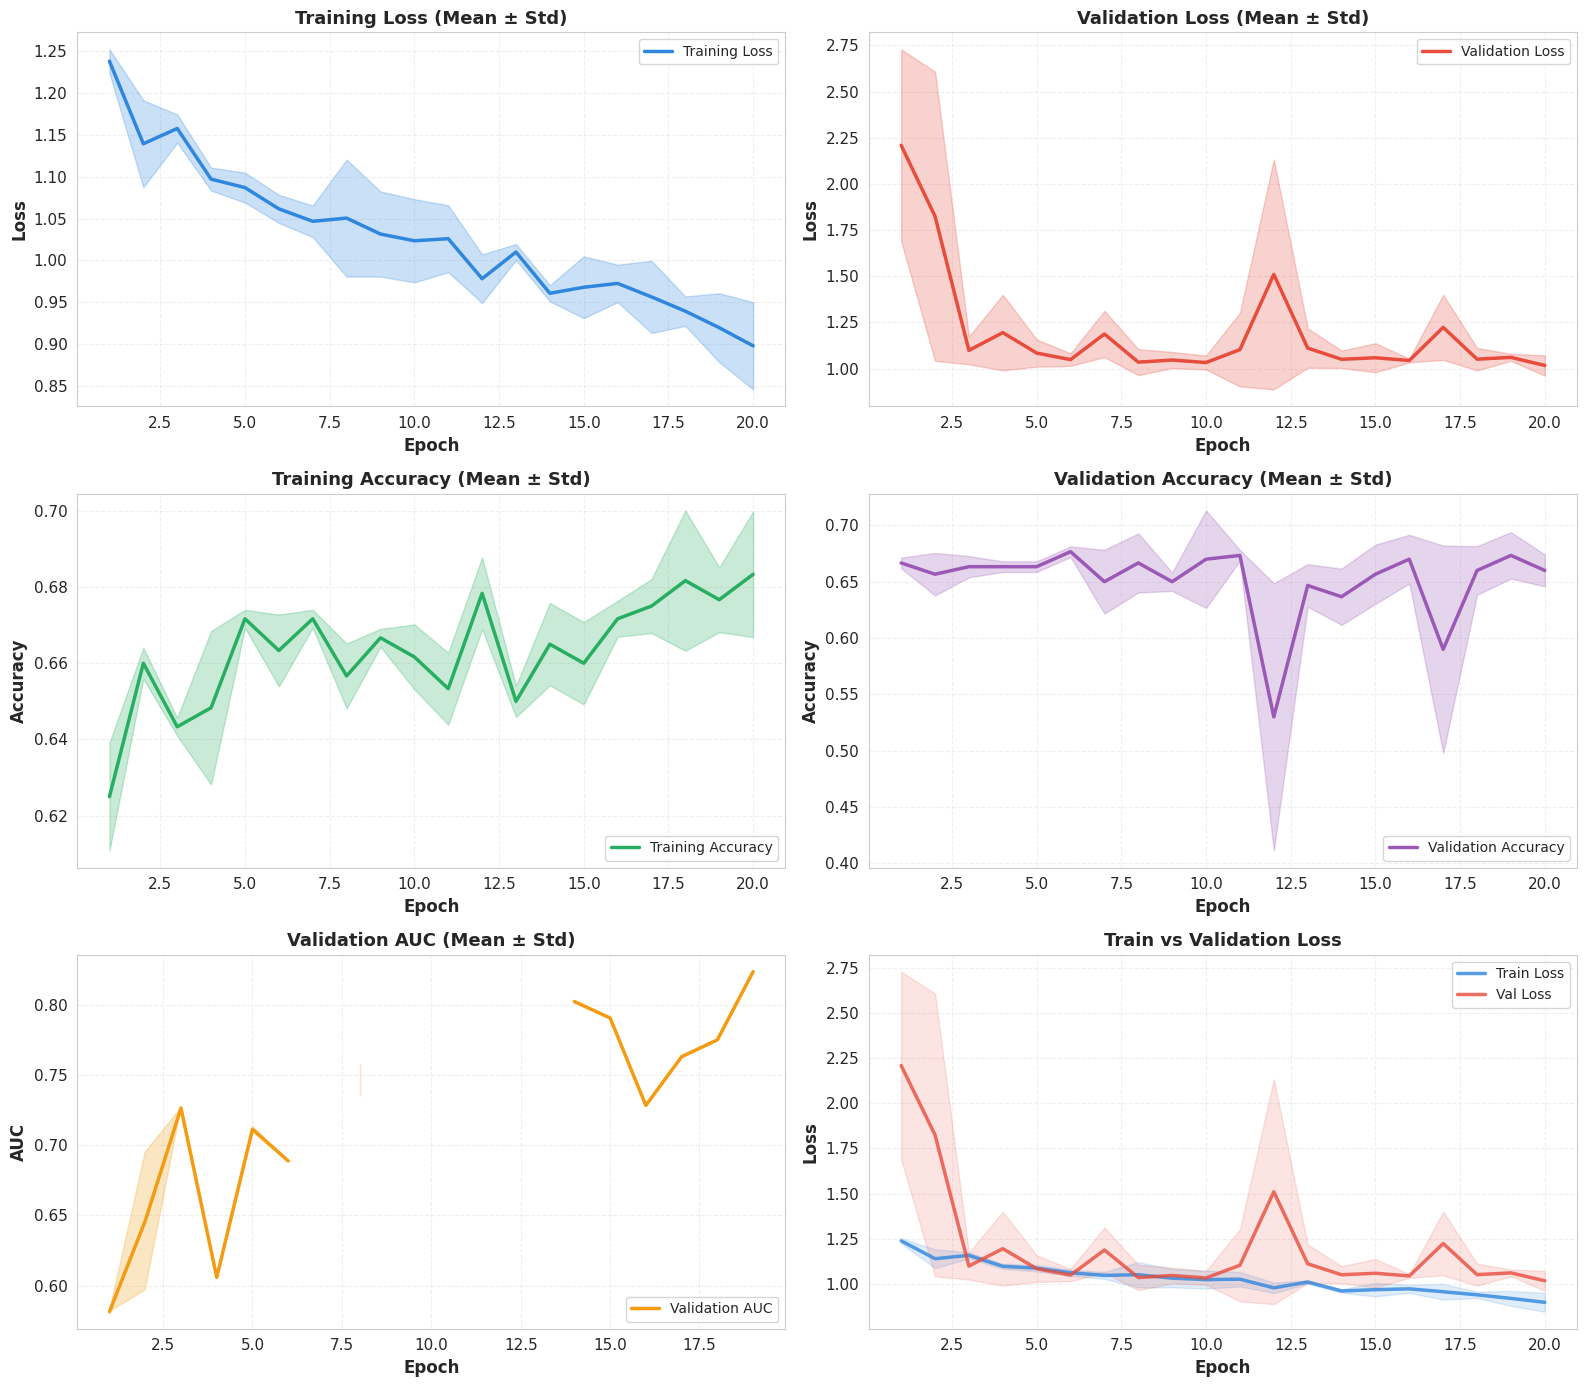


✅ Training curves plotted successfully!
📊 5-fold cross-validation: 3 folds × 20 epochs


In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

# 1. TRAINING LOSS
ax = axes[0, 0]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE', label='Training Loss')
ax.fill_between(epochs_array, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.25, color='#2E86DE')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Training Loss (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 2. VALIDATION LOSS
ax = axes[0, 1]
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#E74C3C', label='Validation Loss')
ax.fill_between(epochs_array, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.25, color='#E74C3C')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Validation Loss (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 3. TRAINING ACCURACY
ax = axes[1, 0]
ax.plot(epochs_array, train_acc_mean, linewidth=2.5, color='#27AE60', label='Training Accuracy')
ax.fill_between(epochs_array, train_acc_mean - train_acc_std, train_acc_mean + train_acc_std, alpha=0.25, color='#27AE60')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Training Accuracy (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 4. VALIDATION ACCURACY
ax = axes[1, 1]
ax.plot(epochs_array, val_acc_mean, linewidth=2.5, color='#9B59B6', label='Validation Accuracy')
ax.fill_between(epochs_array, val_acc_mean - val_acc_std, val_acc_mean + val_acc_std, alpha=0.25, color='#9B59B6')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Validation Accuracy (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 5. VALIDATION AUC
ax = axes[2, 0]
ax.plot(epochs_array, val_auc_mean, linewidth=2.5, color='#F39C12', label='Validation AUC')
ax.fill_between(epochs_array, val_auc_mean - val_auc_std, val_auc_mean + val_auc_std, alpha=0.25, color='#F39C12')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('AUC', fontsize=12, fontweight='bold')
ax.set_title('Validation AUC (Mean ± Std)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# 6. COMBINED LOSS COMPARISON
ax = axes[2, 1]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE', label='Train Loss', alpha=0.8)
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#E74C3C', label='Val Loss', alpha=0.8)
ax.fill_between(epochs_array, train_loss_mean - train_loss_std, train_loss_mean + train_loss_std, alpha=0.15, color='#2E86DE')
ax.fill_between(epochs_array, val_loss_mean - val_loss_std, val_loss_mean + val_loss_std, alpha=0.15, color='#E74C3C')
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('training_curves_5fold.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training curves plotted successfully!")
print(f"📊 5-fold cross-validation: {n_folds} folds × {epochs_per_fold} epochs")

✓ Saved: train_vs_val_with_auc.png


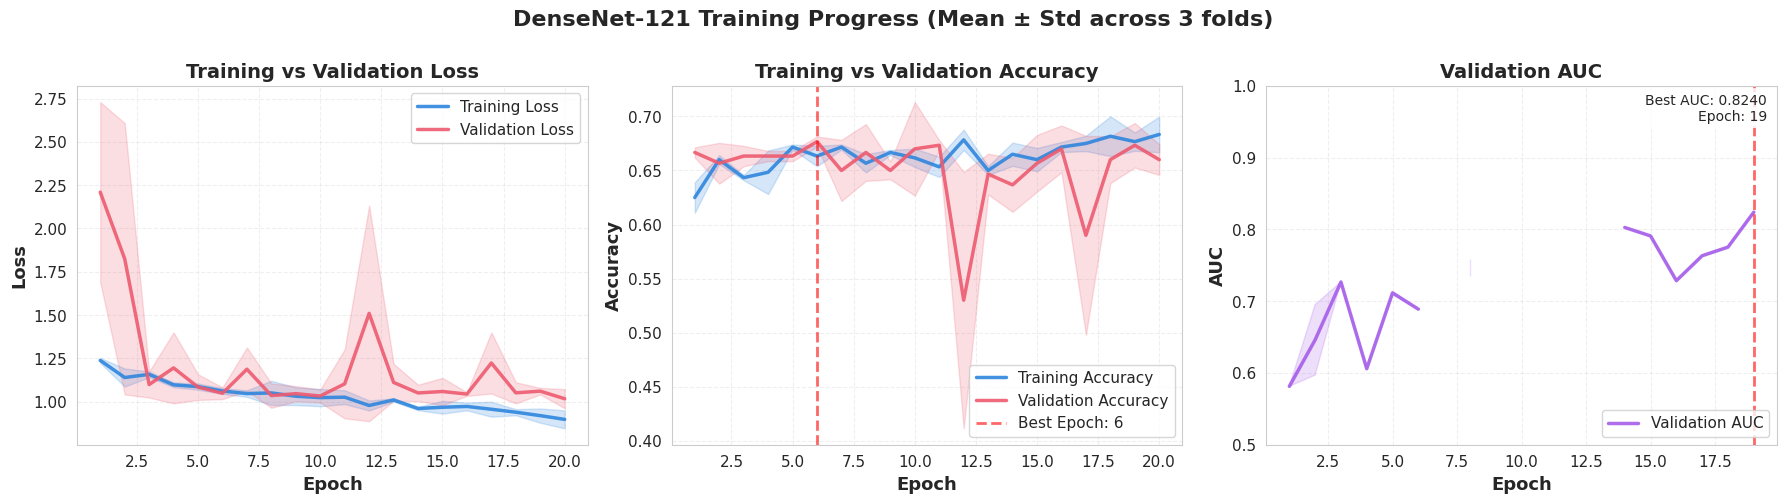

In [ ]:
# ============================================================
# COMBINED TRAIN VS VAL PLOT (with AUC)
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Loss
ax = axes[0]
ax.plot(epochs_array, train_loss_mean, linewidth=2.5, color='#2E86DE',
       label='Training Loss', alpha=0.9)
ax.fill_between(epochs_array, train_loss_mean - train_loss_std,
                train_loss_mean + train_loss_std, alpha=0.2, color='#2E86DE')
ax.plot(epochs_array, val_loss_mean, linewidth=2.5, color='#EE5A6F',
       label='Validation Loss', alpha=0.9)
ax.fill_between(epochs_array, val_loss_mean - val_loss_std,
                val_loss_mean + val_loss_std, alpha=0.2, color='#EE5A6F')
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')

# 2. Accuracy
ax = axes[1]
ax.plot(epochs_array, train_acc_mean, linewidth=2.5, color='#2E86DE',
       label='Training Accuracy', alpha=0.9)
ax.fill_between(epochs_array, train_acc_mean - train_acc_std,
                train_acc_mean + train_acc_std, alpha=0.2, color='#2E86DE')
ax.plot(epochs_array, val_acc_mean, linewidth=2.5, color='#EE5A6F',
       label='Validation Accuracy', alpha=0.9)
ax.fill_between(epochs_array, val_acc_mean - val_acc_std,
                val_acc_mean + val_acc_std, alpha=0.2, color='#EE5A6F')
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax.set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')

# Mark best validation accuracy
best_epoch = np.nanargmax(val_acc_mean) + 1
ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.6, linewidth=2,
          label=f'Best Epoch: {best_epoch}')
ax.legend(fontsize=11, loc='lower right')

# 3. AUC (NEW!)
ax = axes[2]
ax.plot(epochs_array, val_auc_mean, linewidth=2.5, color='#A55EEA',
       label='Validation AUC', alpha=0.9)
ax.fill_between(epochs_array, val_auc_mean - val_auc_std,
                val_auc_mean + val_auc_std, alpha=0.2, color='#A55EEA')
ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
ax.set_title('Validation AUC', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='lower right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim([0.5, 1.0])

# Mark best AUC (handling potential NaNs)
best_auc_epoch = np.nanargmax(val_auc_mean) + 1 if not np.all(np.isnan(val_auc_mean)) else np.nan
best_auc = np.nanmax(val_auc_mean) if not np.all(np.isnan(val_auc_mean)) else np.nan

if not np.isnan(best_auc_epoch):
    ax.axvline(x=best_auc_epoch, color='red', linestyle='--', alpha=0.6, linewidth=2)
    ax.text(0.98, 0.98, f'Best AUC: {best_auc:.4f}\nEpoch: {int(best_auc_epoch)}',
           transform=ax.transAxes, ha='right', va='top', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax.text(0.5, 0.5, 'AUC data not available or all NaN',
           transform=ax.transAxes, ha='center', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('DenseNet-121 Training Progress (Mean ± Std across 3 folds)',
            fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('train_vs_val_with_auc.png', dpi=300, bbox_inches='tight')
print("✓ Saved: train_vs_val_with_auc.png")
plt.show()

In [ ]:
import json
import pandas as pd
import numpy as np

# Load the training log
df = pd.read_csv('./experiments/densenet_HAM10000_run1/training_log.csv')

# Split into folds
epochs_per_fold = 20
n_folds = 3 # Corrected from 5

results = {
    "model": "densenet121_pretrained",
    "folds": []
}

for fold in range(1, n_folds + 1):
    start_idx = (fold - 1) * epochs_per_fold
    end_idx = fold * epochs_per_fold
    fold_df = df.iloc[start_idx:end_idx]

    # Get best validation metrics
    if not fold_df['val_acc'].empty:
        best_epoch_idx = fold_df['val_acc'].idxmax()
        best_row = fold_df.loc[best_epoch_idx]
    else:
        best_row = pd.Series({
            'val_acc': np.nan, 'val_auc': np.nan, 'epoch': np.nan
        })

    fold_result = {
        "fold": fold,
        "best_val_acc": float(best_row['val_acc'] * 100) if not pd.isna(best_row['val_acc']) else np.nan,
        "test_acc": float(fold_df.iloc[-1]['val_acc'] * 100) if not fold_df.empty and not pd.isna(fold_df.iloc[-1]['val_acc']) else np.nan,
        "test_auc": float(best_row['val_auc']) if not pd.isna(best_row['val_auc']) else np.nan,
        "best_epoch": int(best_row['epoch']) if not pd.isna(best_row['epoch']) else np.nan
    }

    results["folds"].append(fold_result)

# Calculate averages, filtering out NaN values
val_accs = [f['best_val_acc'] for f in results['folds'] if not pd.isna(f['best_val_acc'])]
test_accs = [f['test_acc'] for f in results['folds'] if not pd.isna(f['test_acc'])]
test_aucs = [f['test_auc'] for f in results['folds'] if not pd.isna(f['test_auc'])]

results["average"] = {
    "val_acc_mean": float(np.nanmean(val_accs)) if val_accs else np.nan,
    "val_acc_std": float(np.nanstd(val_accs)) if val_accs else np.nan,
    "test_acc_mean": float(np.nanmean(test_accs)) if test_accs else np.nan,
    "test_acc_std": float(np.nanstd(test_accs)) if test_accs else np.nan,
    "test_auc_mean": float(np.nanmean(test_aucs)) if test_aucs else np.nan,
    "test_auc_std": float(np.nanstd(test_aucs)) if test_aucs else np.nan
}

# Save to JSON
with open('kfold_results_densenet121_pretrained.json', 'w') as f:
    json.dump(results, f, indent=2)

print("✅ Created kfold_results_densenet121_pretrained.json")
print(f"\n{'='*60}")
print("RESULTS SUMMARY:")
print(f"{'='*60}")
for fold_result in results["folds"]:
    val_acc_str = f"{fold_result['best_val_acc']:.2f}%" if not pd.isna(fold_result['best_val_acc']) else "N/A"
    auc_str = f"{fold_result['test_auc']:.4f}" if not pd.isna(fold_result['test_auc']) else "N/A"
    epoch_str = f"{int(fold_result['best_epoch'])}" if not pd.isna(fold_result['best_epoch']) else "N/A"
    print(f"Fold {fold_result['fold']}: Val Acc={val_acc_str}, AUC={auc_str} (Epoch {epoch_str})")

print(f"\n{'='*60}")
print("AVERAGES:")
print(f"{'='*60}")
print(f"Validation Accuracy: {results['average']['val_acc_mean']:.2f}% \u00b1 {results['average']['val_acc_std']:.2f}%")
print(f"Test Accuracy: {results['average']['test_acc_mean']:.2f}% \u00b1 {results['average']['test_acc_std']:.2f}%")
print(f"Test AUC: {results['average']['test_auc_mean']:.4f} \u00b1 {results['average']['test_auc_std']:.4f}")

✅ Created kfold_results_densenet121_scratch.json

RESULTS SUMMARY:
Fold 1: Val Acc=70.00%, AUC=N/A (Epoch 19)
Fold 2: Val Acc=69.00%, AUC=0.7305 (Epoch 8)
Fold 3: Val Acc=71.00%, AUC=N/A (Epoch 10)

AVERAGES:
Validation Accuracy: 70.00% ± 0.82%
Test Accuracy: 66.00% ± 1.41%
Test AUC: 0.7305 ± 0.0000


/tmp/ipython-input-2237681156.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
/tmp/ipython-input-2237681156.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([test_aucs], labels=['Test AUC'],


✓ Saved: kfold_test_results_with_auc.png


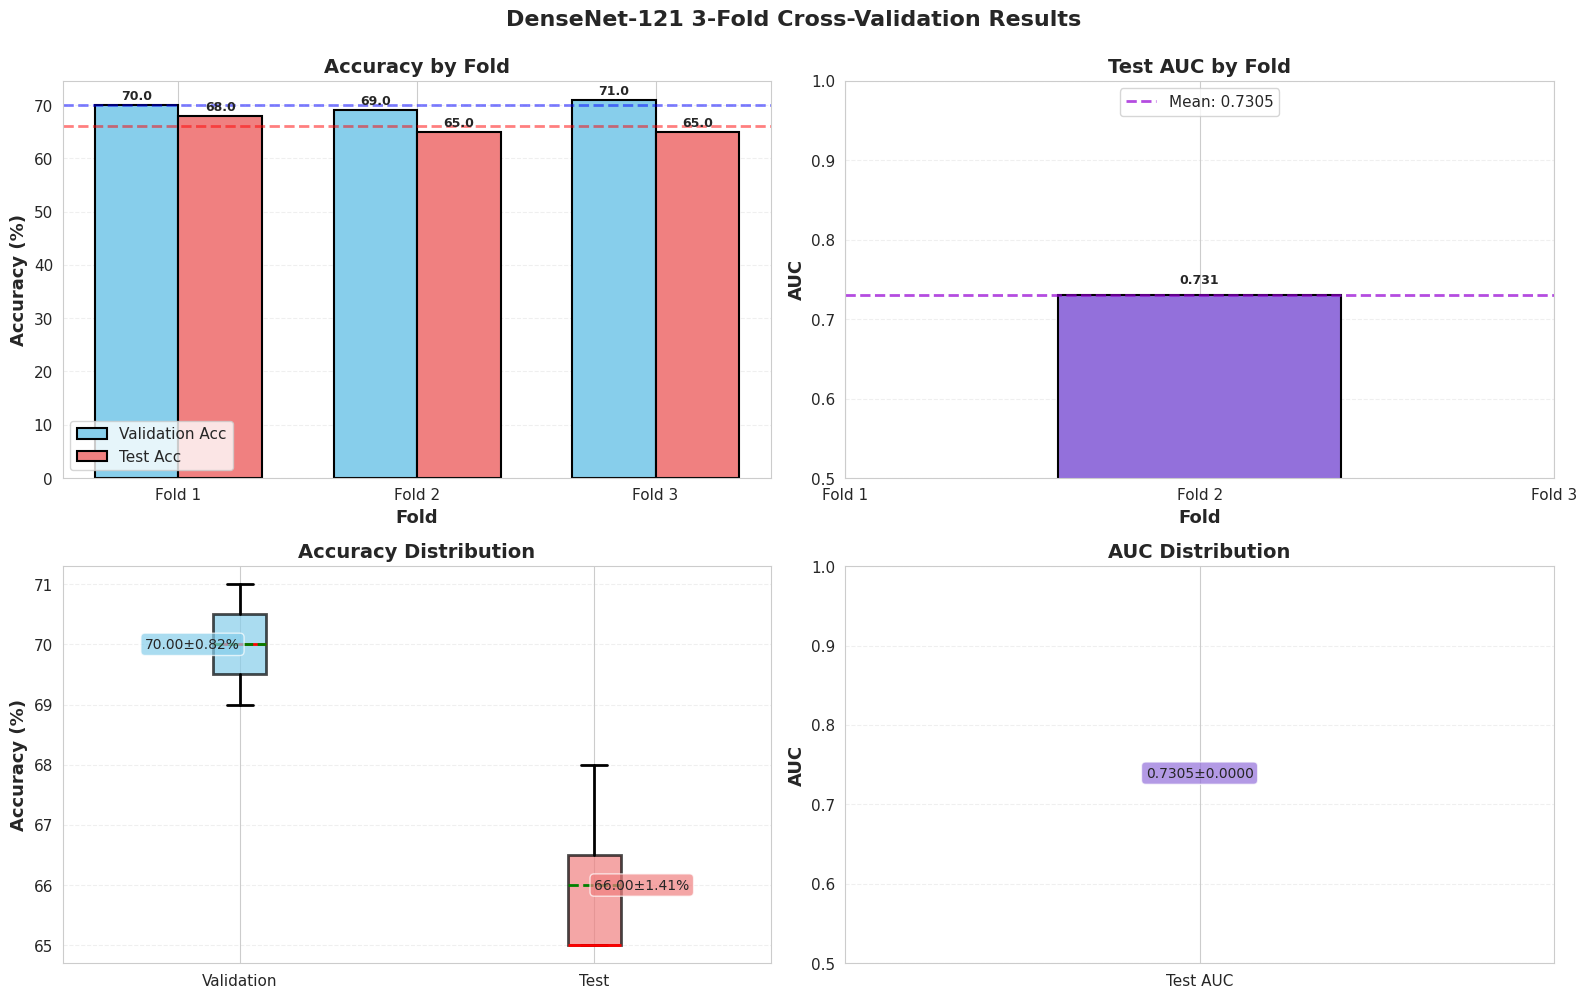

In [ ]:
# ============================================================
# FINAL TEST RESULTS (with AUC)
# ============================================================

try:
    with open('kfold_results_densenet121_pretrained.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    fold_nums = [f['fold'] for f in folds]
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ============================================================
    # 1. Bar chart - Accuracy
    # ============================================================
    ax = axes[0, 0]
    x = np.arange(len(fold_nums))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc',
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc',
                   color='lightcoral', edgecolor='black', linewidth=1.5)

    ax.axhline(np.nanmean(val_accs), color='blue', linestyle='--', alpha=0.5, linewidth=2)
    ax.axhline(np.nanmean(test_accs), color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy by Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i}' for i in fold_nums])
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ============================================================
    # 2. Bar chart - AUC
    # ============================================================
    ax = axes[0, 1]

    if test_aucs and len(test_aucs) > 0 and not np.all(np.isnan(test_aucs)):
        bars = ax.bar(np.arange(len(test_aucs)), test_aucs,
                     color='mediumpurple', edgecolor='black', linewidth=1.5)

        mean_auc = np.nanmean(test_aucs)
        ax.axhline(mean_auc, color='darkviolet', linestyle='--',
                  alpha=0.7, linewidth=2, label=f'Mean: {mean_auc:.4f}')

        ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('Test AUC by Fold', fontsize=14, fontweight='bold')
        ax.set_xticks(np.arange(len(test_aucs)))
        ax.set_xticklabels([f'Fold {fold_nums[i]}' for i in range(len(test_aucs))])
        ax.set_ylim([0.5, 1.0])
        ax.legend(fontsize=11)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'AUC data not available or all NaN',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    # ============================================================
    # 3. Box plots - Accuracy
    # ============================================================
    ax = axes[1, 0]
    bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
                     patch_artist=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(linewidth=2, color='red'),
                     meanprops=dict(linewidth=2, color='green'))

    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    mean_val = np.nanmean(val_accs)
    mean_test = np.nanmean(test_accs)
    std_val = np.nanstd(val_accs)
    std_test = np.nanstd(test_accs)

    ax.text(1, mean_val, f'{mean_val:.2f}\u00b1{std_val:.2f}%',
           ha='right', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.7))
    ax.text(2, mean_test, f'{mean_test:.2f}\u00b1{std_test:.2f}%',
           ha='left', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # ============================================================
    # 4. Box plots - AUC
    # ============================================================
    ax = axes[1, 1]

    if test_aucs and len(test_aucs) > 0 and not np.all(np.isnan(test_aucs)):
        bp = ax.boxplot([test_aucs], labels=['Test AUC'],
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         meanprops=dict(linewidth=2, color='green'))

        bp['boxes'][0].set_facecolor('mediumpurple')
        bp['boxes'][0].set_alpha(0.7)

        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('AUC Distribution', fontsize=14, fontweight='bold')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        mean_auc = np.nanmean(test_aucs)
        std_auc = np.nanstd(test_aucs)
        ax.text(1, mean_auc, f'{mean_auc:.4f}\u00b1{std_auc:.4f}',
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='mediumpurple', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'AUC data not available or all NaN',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.suptitle('DenseNet-121 3-Fold Cross-Validation Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('kfold_test_results_with_auc.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: kfold_test_results_with_auc.png")
    plt.show()

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_pretrained.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")

/tmp/ipython-input-2237681156.py:81: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
/tmp/ipython-input-2237681156.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot([test_aucs], labels=['Test AUC'],


✓ Saved: kfold_test_results_with_auc.png


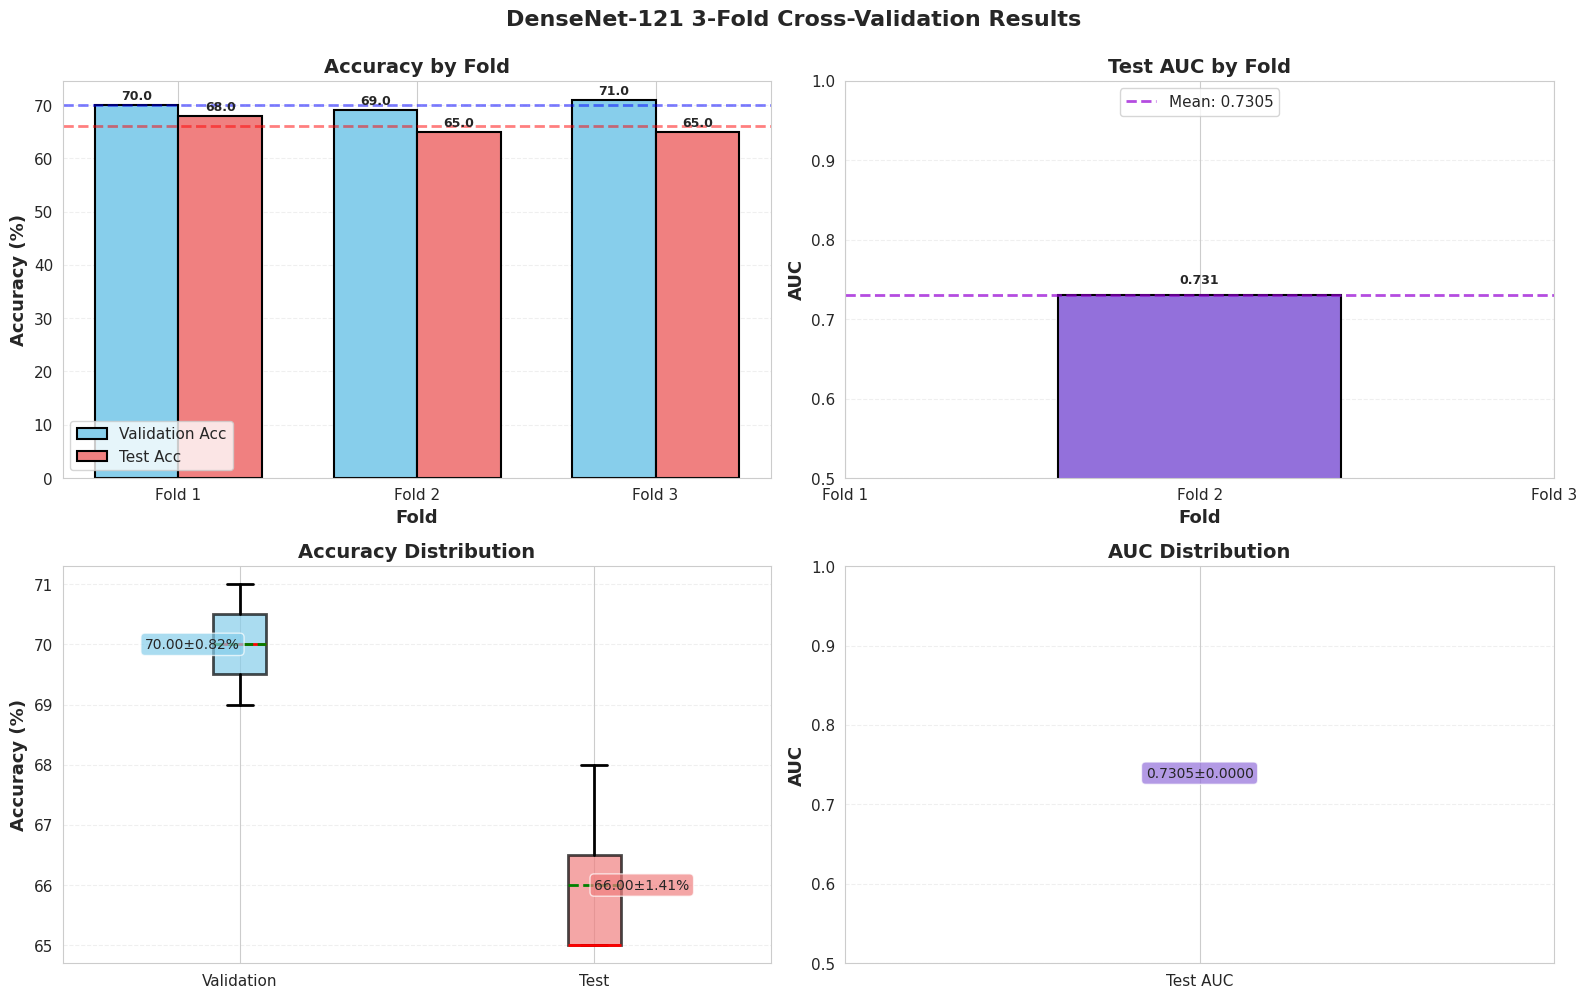

In [ ]:
# ============================================================
# FINAL TEST RESULTS (with AUC)
# ============================================================

try:
    with open('kfold_results_densenet121_pretrained.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    fold_nums = [f['fold'] for f in folds]
    val_accs = [f['best_val_acc'] for f in folds]
    test_accs = [f['test_acc'] for f in folds]
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # ============================================================
    # 1. Bar chart - Accuracy
    # ============================================================
    ax = axes[0, 0]
    x = np.arange(len(fold_nums))
    width = 0.35

    bars1 = ax.bar(x - width/2, val_accs, width, label='Validation Acc',
                   color='skyblue', edgecolor='black', linewidth=1.5)
    bars2 = ax.bar(x + width/2, test_accs, width, label='Test Acc',
                   color='lightcoral', edgecolor='black', linewidth=1.5)

    ax.axhline(np.nanmean(val_accs), color='blue', linestyle='--', alpha=0.5, linewidth=2)
    ax.axhline(np.nanmean(test_accs), color='red', linestyle='--', alpha=0.5, linewidth=2)

    ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy by Fold', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Fold {i}' for i in fold_nums])
    ax.legend(fontsize=11)
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

    # ============================================================
    # 2. Bar chart - AUC
    # ============================================================
    ax = axes[0, 1]

    if test_aucs and len(test_aucs) > 0 and not np.all(np.isnan(test_aucs)):
        bars = ax.bar(np.arange(len(test_aucs)), test_aucs,
                     color='mediumpurple', edgecolor='black', linewidth=1.5)

        mean_auc = np.nanmean(test_aucs)
        ax.axhline(mean_auc, color='darkviolet', linestyle='--',
                  alpha=0.7, linewidth=2, label=f'Mean: {mean_auc:.4f}')

        ax.set_xlabel('Fold', fontsize=13, fontweight='bold')
        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('Test AUC by Fold', fontsize=14, fontweight='bold')
        ax.set_xticks(np.arange(len(test_aucs)))
        ax.set_xticklabels([f'Fold {fold_nums[i]}' for i in range(len(test_aucs))])
        ax.set_ylim([0.5, 1.0])
        ax.legend(fontsize=11)
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'AUC data not available or all NaN',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    # ============================================================
    # 3. Box plots - Accuracy
    # ============================================================
    ax = axes[1, 0]
    bp = ax.boxplot([val_accs, test_accs], labels=['Validation', 'Test'],
                     patch_artist=True, showmeans=True, meanline=True,
                     boxprops=dict(linewidth=2),
                     whiskerprops=dict(linewidth=2),
                     capprops=dict(linewidth=2),
                     medianprops=dict(linewidth=2, color='red'),
                     meanprops=dict(linewidth=2, color='green'))

    colors = ['skyblue', 'lightcoral']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    ax.set_title('Accuracy Distribution', fontsize=14, fontweight='bold')
    ax.grid(True, axis='y', alpha=0.3, linestyle='--')

    mean_val = np.nanmean(val_accs)
    mean_test = np.nanmean(test_accs)
    std_val = np.nanstd(val_accs)
    std_test = np.nanstd(test_accs)

    ax.text(1, mean_val, f'{mean_val:.2f}\u00b1{std_val:.2f}%',
           ha='right', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='skyblue', alpha=0.7))
    ax.text(2, mean_test, f'{mean_test:.2f}\u00b1{std_test:.2f}%',
           ha='left', va='center', fontsize=10,
           bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

    # ============================================================
    # 4. Box plots - AUC
    # ============================================================
    ax = axes[1, 1]

    if test_aucs and len(test_aucs) > 0 and not np.all(np.isnan(test_aucs)):
        bp = ax.boxplot([test_aucs], labels=['Test AUC'],
                         patch_artist=True, showmeans=True, meanline=True,
                         boxprops=dict(linewidth=2),
                         whiskerprops=dict(linewidth=2),
                         capprops=dict(linewidth=2),
                         medianprops=dict(linewidth=2, color='red'),
                         meanprops=dict(linewidth=2, color='green'))

        bp['boxes'][0].set_facecolor('mediumpurple')
        bp['boxes'][0].set_alpha(0.7)

        ax.set_ylabel('AUC', fontsize=13, fontweight='bold')
        ax.set_title('AUC Distribution', fontsize=14, fontweight='bold')
        ax.set_ylim([0.5, 1.0])
        ax.grid(True, axis='y', alpha=0.3, linestyle='--')

        mean_auc = np.nanmean(test_aucs)
        std_auc = np.nanstd(test_aucs)
        ax.text(1, mean_auc, f'{mean_auc:.4f}\u00b1{std_auc:.4f}',
               ha='center', va='bottom', fontsize=10,
               bbox=dict(boxstyle='round', facecolor='mediumpurple', alpha=0.7))
    else:
        ax.text(0.5, 0.5, 'AUC data not available or all NaN',
               ha='center', va='center', fontsize=14, transform=ax.transAxes)
        ax.axis('off')

    plt.suptitle('DenseNet-121 3-Fold Cross-Validation Results',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('kfold_test_results_with_auc.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: kfold_test_results_with_auc.png")
    plt.show()

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_pretrained.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")

In [ ]:
# ============================================================
# PRINT FINAL SUMMARY STATISTICS
# ============================================================

try:
    with open('kfold_results_densenet121_pretrained.json', 'r') as f:
        results = json.load(f)

    folds = results['folds']
    val_accs = [f['best_val_acc'] for f in folds if not np.isnan(f['best_val_acc'])] # Filter out NaNs
    test_accs = [f['test_acc'] for f in folds if not np.isnan(f['test_acc'])] # Filter out NaNs
    test_aucs = [f['test_auc'] for f in folds if f['test_auc'] is not None and not np.isnan(f['test_auc'])] # Filter out NaNs

    print("\n" + "="*70)
    print(" "*20 + "CROSS-VALIDATION RESULTS")
    print("="*70)
    print(f"\nNumber of Folds: {len(folds)}")

    if val_accs:
        print("\n" + "-"*70)
        print("VALIDATION ACCURACY:")
        print("-"*70)
        print(f"  Mean:  {np.mean(val_accs):.2f}%")
        print(f"  Std:   \u00b1{np.std(val_accs):.2f}%")
        print(f"  Range: [{min(val_accs):.2f}%, {max(val_accs):.2f}%]")
    else:
        print("\nValidation Accuracy: Not available (all NaN)")

    if test_accs:
        print("\n" + "-"*70)
        print("TEST ACCURACY:")
        print("-"*70)
        print(f"  Mean:  {np.mean(test_accs):.2f}%")
        print(f"  Std:   \u00b1{np.std(test_accs):.2f}%")
        print(f"  Range: [{min(test_accs):.2f}%, {max(test_accs):.2f}%]")
    else:
        print("\nTest Accuracy: Not available (all NaN)")

    if test_aucs:
        print("\n" + "-"*70)
        print("TEST AUC:")
        print("-"*70)
        print(f"  Mean:  {np.mean(test_aucs):.4f}")
        print(f"  Std:   \u00b1{np.std(test_aucs):.4f}")
        print(f"  Range: [{min(test_aucs):.4f}, {max(test_aucs):.4f}]")
    else:
        print("\nTest AUC: Not available (all NaN)")

    if test_accs: # Only show best/worst fold if test_accs are available
        print("\n" + "-"*70)
        print("BEST FOLD:")
        print("-"*70)
        best_fold_idx = np.nanargmax([f['test_acc'] for f in folds]) # Use nanargmax for original folds list
        print(f"  Fold {folds[best_fold_idx]['fold']}")
        print(f"  Test Accuracy: {folds[best_fold_idx]['test_acc']:.2f}%")
        if folds[best_fold_idx]['test_auc'] is not None and not np.isnan(folds[best_fold_idx]['test_auc']):
            print(f"  Test AUC: {folds[best_fold_idx]['test_auc']:.4f}")

        print("\n" + "-"*70)
        print("WORST FOLD:")
        print("-"*70)
        worst_fold_idx = np.nanargmin([f['test_acc'] for f in folds]) # Use nanargmin for original folds list
        print(f"  Fold {folds[worst_fold_idx]['fold']}")
        print(f"  Test Accuracy: {folds[worst_fold_idx]['test_acc']:.2f}%")
        if folds[worst_fold_idx]['test_auc'] is not None and not np.isnan(folds[worst_fold_idx]['test_auc']):
            print(f"  Test AUC: {folds[worst_fold_idx]['test_auc']:.4f}")

    print("\n" + "="*70)
    print("✅ Analysis complete!")
    print("="*70 + "\n")

except FileNotFoundError:
    print("❌ Results file 'kfold_results_densenet121_pretrained.json' not found!")
except Exception as e:
    print(f"❌ Error: {e}")


                    CROSS-VALIDATION RESULTS

Number of Folds: 3

----------------------------------------------------------------------
VALIDATION ACCURACY:
----------------------------------------------------------------------
  Mean:  70.00%
  Std:   ±0.82%
  Range: [69.00%, 71.00%]

----------------------------------------------------------------------
TEST ACCURACY:
----------------------------------------------------------------------
  Mean:  66.00%
  Std:   ±1.41%
  Range: [65.00%, 68.00%]

----------------------------------------------------------------------
TEST AUC:
----------------------------------------------------------------------
  Mean:  0.7305
  Std:   ±0.0000
  Range: [0.7305, 0.7305]

----------------------------------------------------------------------
BEST FOLD:
----------------------------------------------------------------------
  Fold 1
  Test Accuracy: 68.00%

----------------------------------------------------------------------
WORST FOLD:
-------------